 **How to read this notebook**
-
[README](https://github.com/Yuri-Ian/real-estate-pricing-insights) in both Russian and English.

The core analysis is presented in Russian.
For international reviewers, each section is provided in both Russian and English and begins with short guides for quick navigation:

🔷 **Data sidenote** — key takeaways and findings.

🔶 **Code sidenote** — brief explanation of why and how methods were applied.

Placing these notes at the start of each section makes it easier to grasp the logic of the analysis without reading through the full details.

*P.S.*

*This notebook reflects one of my first structured ML projects. I put significant effort into documenting the reasoning behind every step, clarifying why methods were chosen and how results were validated. The focus was on transparency and structured workflow, rather than compactness. In real production projects I would use more concise text and rely on pipelines, automated preprocessing, and extended visualizations. Preserving this version shows how I pay attention to detail and communicate analytical thinking.*



## Navigation / Навигация

- [Загрузим и изучим данные](#load-data)
- [Предобработка данных](#preprocessing)
- [Исследовательский анализ данных (EDA)](#eda)
- [Корреляционный анализ](#correlation)
- [Обучение модели линейной регрессии](#linear-regression)
- [Обучение модели логистической регрессии](#logistic-regression)
- [Итоговые выводы](#conclusion)


<a id="load-data"></a>
#### Загрузим и изучим данные / Load and inspect the data

<a id="preprocessing"></a>
#### Предобработка данных / Data preprocessing

<a id="eda"></a>
#### Исследовательский анализ данных / Exploratory Data Analysis (EDA)

<a id="correlation"></a>
#### Корреляционный анализ / Correlation analysis

<a id="linear-regression"></a>
#### Обучение модели линейной регрессии / Training a linear regression model

<a id="logistic-regression"></a>
#### Обучение модели логистической регрессии / Training a logistic regression model

<a id="conclusion"></a>
#### Итоговые выводы / General Conclusion


**Описание проекта**

Проект реализуется по заказу молочного хозяйства «Вольный луг», которое планирует расширить стадо и приобрести новых коров у партнёра — «ЭкоФерма». Ключевая потребность заказчика — сократить риски при покупке, основываясь не на субъективных оценках, а на объективных данных.

На основе прогнозов заказчик сможет принимать обоснованные решения о покупке животных, соответствующих его требованиям по производительности и качеству молока.

**Цель проекта:**

Разработать аналитический инструмент на базе моделей машинного обучения, позволяющий:

- Прогнозировать продуктивность коров (удой, кг/год);

- Оценивать вероятность вкусовых характеристик молока (вкусно / не вкусно);

- Автоматизировать отбор животных, соответствующих критериям качества и объёмов.

**Задачи:**

- Провести анализ и подготовку данных, полученных от заказчика;

- Исследовать взаимосвязи между признаками, влияющими на удой и вкус молока;

- Построить и сравнить модели линейной регрессии для прогнозирования удоя;

- Построить модель логистической регрессии для оценки вкуса молока;

- Применить модели для анализа коров из списка на покупку;

- Отобрать животных, соответствующих ключевым критериям (>6000 кг/год, вкусное молоко);

- Подготовить визуализации, метрики качества моделей и финальные рекомендации для заказчика.

In [ ]:
# Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from scipy import stats
from scipy.stats import norm
from scipy.stats import pearsonr

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### 1. Загрузим и изучим данные / Load and inspect the data

🔷 **Data sidenote**

- Targets: milk yield and taste quality.
- Data contain mixed numeric and categorical features with some gaps.
- Ready for cleaning, but initial summaries limited by outliers and NaNs.

🔶 **Code sidenote**

- Load 3 datasets: ferma_main.csv (sep=';', decimal=','), ferma_dad.csv, cow_buy.csv.
- Inspect shape, types, and missing values.
- Preview rows to confirm schema and categories.
- Normalize column names: lowercase, underscores.

---

Загрузим и изучим данные. Определим, соответствуют ли они описанию задачи и стандартам оформления данных.

In [ ]:
# Извлечение файлов с данными в переменные

ferma_main = pd.read_csv('/content/ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('/content/ferma_dad.csv', sep=';')
cow_buy = pd.read_csv('/content/cow_buy.csv', sep=';', decimal=',')

In [ ]:
# Посмотрим на первые пять строк каждого датасета

display(ferma_main.head())
display(ferma_dad.head())
display(cow_buy.head())

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет

**Описание данных**

**Датасет `ferma_main`** — информация о текущем стаде фермера:
- `id` — уникальный идентификатор коровы  
- `Удой, кг` — масса молока, которую корова даёт в год (в килограммах)  
- `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма  
- `Сырой протеин, г` — содержание сырого протеина в корме (в граммах)  
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме  
- `Порода` — порода коровы  
- `Тип пастбища` — ландшафт лугов, на которых паслась корова  
- `порода папы_быка` — порода отца коровы  
- `Жирность,%` — содержание жиров в молоке (в процентах)  
- `Белок,%` — содержание белков в молоке (в процентах)  
- `Вкус молока` — субъективная оценка вкуса молока (вкусно / не вкусно)  
- `Возраст` — возраст коровы (менее_2_лет / более_2_лет)  

**Группировка признаков:**
- *Характеристики коровы:* `id`, `Порода`, `порода папы_быка`, `Возраст`  
- *Характеристики корма:* `ЭКЕ`, `Сырой протеин, г`, `СПО`  
- *Характеристика пастбища:* `Тип пастбища`  
- *Характеристики молока:* `Удой, кг`, `Жирность,%`, `Белок,%`, `Вкус молока`  

---

**Датасет `ferma_dad`** — информация об отцах коров:
- `id` — уникальный идентификатор коровы  
- `Имя Папы` — имя отца коровы  

---

**Датасет `cow_buy`** — потенциальные коровы на покупку от «ЭкоФерма»:
- `Порода` — порода коровы  
- `Тип пастбища` — ландшафт лугов, где паслась корова  
- `порода папы_быка` — порода отца коровы  
- `Имя_папы` — имя отца коровы  
- `Текущая_жирность,%` — содержание жиров в молоке в момент продажи  
- `Текущий_уровень_белок,%` — содержание белков в молоке в момент продажи  
- `Возраст` — возраст коровы (менее_2_лет / более_2_лет)  

In [ ]:
# Изучим общую информацию о датасетах

display(ferma_main.info())
display(ferma_dad.info())
display(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

**Вывод по структуре данных**

Мы успешно загрузили три датасета и изучили их структуру:

- 'ferma_main' содержит 634 записи и 12 признаков. Это основной датасет, на основе которого мы будем строить модели. Он включает как числовые, так и категориальные признаки, а также два целевых столбца — Удой, кг и Вкус молока. Однако часть числовых признаков (ЭКЕ, СПО, Жирность,%, Белок,%) имеют тип object, что требует предварительного преобразования в числовой формат.

- 'ferma_dad' содержит 629 строк и 2 столбца: id и Имя Папы. Это вспомогательный датасет, который поможет расширить основной ferma_main, добавив информацию о родословной.

- 'cow_buy' включает 20 записей и 7 признаков. Это данные о коровах, которых фермер рассматривает для покупки. Здесь также все признаки имеют тип object, включая числовые показатели (Текущая_жирность,% и Текущий_уровень_белок,%). Признаки кормления в этом датасете отсутствуют и будут добавлены позднее вручную на основе средних значений с поправкой.

In [ ]:
# Переименуем столбцы для удобства дальнейшей работы

# Функция для нормализации названий столбцов
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()                         # убираем пробелы по краям
        .str.lower()                         # переводим в нижний регистр
        .str.replace(' ', '_')               # заменяем пробелы на _
        .str.replace(',', '')                # удаляем запятые
        .str.replace('%', 'проц')            # заменяем знак % на "проц"
        .str.replace('(', '', regex=False)   # убираем скобки
        .str.replace(')', '', regex=False)   # убираем скобки
        .str.replace('__', '_')              # двойное подчёркивание -> одинарное
    )
    return df

# Применяем ко всем датасетам
ferma_main = clean_column_names(ferma_main)
ferma_dad = clean_column_names(ferma_dad)
cow_buy = clean_column_names(cow_buy)

# Проверим результат
display(ferma_main.info())
display(ferma_dad.info())
display(cow_buy.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   634 non-null    int64  
 1   удой_кг                              634 non-null    int64  
 2   эке_энергетическая_кормовая_единица  634 non-null    float64
 3   сырой_протеин_г                      634 non-null    int64  
 4   спо_сахаро-протеиновое_соотношение   634 non-null    float64
 5   порода                               634 non-null    object 
 6   тип_пастбища                         634 non-null    object 
 7   порода_папы_быка                     634 non-null    object 
 8   жирностьпроц                         634 non-null    float64
 9   белокпроц                            634 non-null    float64
 10  вкус_молока                          634 non-null    object 
 11  возраст                         

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   порода                     20 non-null     object 
 1   тип_пастбища               20 non-null     object 
 2   порода_папы_быка           20 non-null     object 
 3   имя_папы                   20 non-null     object 
 4   текущая_жирностьпроц       20 non-null     float64
 5   текущий_уровень_белокпроц  20 non-null     float64
 6   возраст                    20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

Столбцы во всех трёх датасетах успешно переименованы: теперь они приведены к единому стилю — в нижнем регистре, без пробелов и специальных символов. Это значительно упростит дальнейшую работу с признаками при анализе и построении моделей.

Мы также видим, что часть признаков, которые по смыслу являются числовыми (`эке`, `спо`, `жирностьпроц`, `белокпроц`), пока имеют тип `object` — это потребует дополнительного преобразования.

В следующем шаге проверим данные на наличие пропусков, дубликатов и приведём числовые признаки к нужному типу.

#### 2. Предобработка данных / Data preprocessing

🔷 **Data sidenote**

- Data types aligned, categories unified — eliminates hidden noise sources.
- Dataset cleaned and consistent; ready for EDA and modeling.

🔶 **Code sidenote**

- Cast numeric columns to float
- Normalize categorical values (fix typos/variants)
- Check for missing values and duplicates.

---

Проверим данные на наличие пропусков и дубликатов. Выясним, корректны ли типы данных у каждого признака. При необходимости устраним обнаруженные проблемы с данными.

**Преобразование типов данных**

В нескольких столбцах изначально числовые значения были представлены как строки (тип `object`), так как использовали запятую в качестве десятичного разделителя (например, `'3,58'` вместо `'3.58'`). Чтобы модели машинного обучения могли с ними работать, мы выполнили преобразование в формат `float`.

**В таблице `ferma_main` были преобразованы следующие столбцы:**
- `эке_энергетическая_кормовая_единица` — показатель питательности корма;
- `спо_сахаро-протеиновое_соотношение` — отношение сахара к протеину;
- `жирностьпроц` — содержание жиров в молоке;
- `белокпроц` — содержание белков в молоке.

**В таблице `cow_buy` были преобразованы:**
- `текущая_жирностьпроц` — жирность молока у коров, выставленных на продажу;
- `текущий_уровень_белокпроц` — содержание белков в молоке этих коров.

Теперь признаки имеют корректный тип и готовы к дальнейшему анализу.


In [ ]:
# Проверка и очистка дубликатов + нормализация текстов

# Функция для поиска дубликатов
def check_duplicates(df, name):
    print(f"\n Явные дубликаты в {name}: {df.duplicated().sum()}")

    # Проверяем полные дубликаты (все признаки)
    full_subset = df.columns.tolist()
    duplicates = (
        df[df.duplicated(subset=full_subset, keep='first')]
        .groupby(full_subset)
        .size()
        .reset_index(name='количество')
        .sort_values(by='количество', ascending=False)
    )

    if not duplicates.empty:
        display(duplicates.head())
    else:
        print(f" Полные дубликаты в {name} не найдены.")

# Функция для нормализации текстовых значений
def normalize_string_columns(df):
    for col in df.select_dtypes(include='object').columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .str.replace(' ', '_')
        )
    return df

# Обрабатываем датасеты
datasets = {
    'ferma_main': ferma_main,
    'ferma_dad': ferma_dad,
    'cow_buy': cow_buy
}

for name, df in datasets.items():
    check_duplicates(df, name)
    df.drop_duplicates(keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    datasets[name] = normalize_string_columns(df)

# Распаковываем обратно
ferma_main = datasets['ferma_main']
ferma_dad = datasets['ferma_dad']
cow_buy = datasets['cow_buy']

# Визуально убедимся, что нормализация сработала
print("\n Примеры нормализованных значений:")
display(ferma_main[['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']].drop_duplicates().head())
display(cow_buy[['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст']].drop_duplicates().head())
display(ferma_dad[['имя_папы']].drop_duplicates().head())



 Явные дубликаты в ferma_main: 5


id  удой_кг  эке_энергетическая_кормовая_единица  сырой_протеин_г  \
0  627     5970                                 14.4             1837   

   спо_сахаро-протеиновое_соотношение           порода тип_пастбища  \
0                                0.88  РефлешнСоверинг    Холмистое   

  порода_папы_быка  жирностьпроц  белокпроц вкус_молока      возраст  \
0          Соверин          3.64      3.075   не вкусно  более_2_лет   

   количество  
0           5


 Явные дубликаты в ferma_dad: 0
 Полные дубликаты в ferma_dad не найдены.

 Явные дубликаты в cow_buy: 4


порода тип_пастбища порода_папы_быка  имя_папы  \
2  РефлешнСоверинг    равнинное          Соверин     Барин   
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   текущая_жирностьпроц  текущий_уровень_белокпроц      возраст  количество  
2                  3.59                      3.074  более_2_лет           2  
0                  3.58                      3.076  более_2_лет           1  
1                  3.64                      3.074  более_2_лет           1


 Примеры нормализованных значений:


порода тип_пастбища порода_папы_быка      возраст
0   вис_бик_айдиал    равнинное           айдиал  более_2_лет
1   вис_бик_айдиал    равнинные          соверин  менее_2_лет
2  рефлешнсоверинг    холмистое          соверин  более_2_лет
3  рефлешнсоверинг    холмистое           айдиал  более_2_лет
5  рефлешнсоверинг    холмистое          соверин  менее_2_лет

порода тип_пастбища порода_папы_быка  имя_папы      возраст
0   вис_бик_айдиал    холмистое           айдиал  геркулес  более_2_лет
1   вис_бик_айдиал    равнинное          соверин    буйный  менее_2_лет
2  рефлешнсоверинг    равнинное          соверин     барин  более_2_лет
3  рефлешнсоверинг    холмистое           айдиал    буйный  более_2_лет
4  рефлешнсоверинг    равнинное           айдиал    буйный  более_2_лет

имя_папы
0    буйный
1  соловчик
2     барин
7  геркулес

In [ ]:
# Функция для вывода уникальных значений в категориальных признаках
def check_similar_values(df, columns):
    for col in columns:
        print(f"\n - Уникальные значения в '{col}':")
        display(pd.Series(df[col].unique()).sort_values())

print("\n Проверка 'ferma_main' на неявные дубликаты")
check_similar_values(ferma_main, ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст'])
print("\n Проверка 'cow_buy' на неявные дубликаты")
check_similar_values(cow_buy, ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст'])



 Проверка 'ferma_main' на неявные дубликаты

 - Уникальные значения в 'порода':


0     вис_бик_айдиал
1    рефлешнсоверинг
dtype: object


 - Уникальные значения в 'тип_пастбища':


0    равнинное
1    равнинные
2    холмистое
dtype: object


 - Уникальные значения в 'порода_папы_быка':


0     айдиал
2    айдиалл
1    соверин
dtype: object


 - Уникальные значения в 'возраст':


0    более_2_лет
1    менее_2_лет
dtype: object


 Проверка 'cow_buy' на неявные дубликаты

 - Уникальные значения в 'порода':


0     вис_бик_айдиал
1    рефлешнсоверинг
dtype: object


 - Уникальные значения в 'тип_пастбища':


1    равнинное
0    холмистое
dtype: object


 - Уникальные значения в 'порода_папы_быка':


0     айдиал
1    соверин
dtype: object


 - Уникальные значения в 'имя_папы':


2       барин
1      буйный
0    геркулес
3    соловчик
dtype: object


 - Уникальные значения в 'возраст':


0    более_2_лет
1    менее_2_лет
dtype: object

В ходе проверки уникальных значений категориальных признаков были обнаружены **неявные дубликаты** — строки, которые различались лишь по написанию (например, «айдиал» и «айдиалл», «равнинное» и «равнинные»).

In [ ]:
# Словари исправлений неявных дубликатов
replace_dict_main = {
    'тип_пастбища': {
        'равнинные': 'равнинное'
    },
    'порода_папы_быка': {
        'айдиалл': 'айдиал'
    }
}

replace_dict_cow = {
    'тип_пастбища': {
        'равнинные': 'равнинное'
    }
}

# Применяем замены в ferma_main
for col, replace_map in replace_dict_main.items():
    ferma_main[col] = ferma_main[col].replace(replace_map)

# Применяем замены в cow_buy
for col, replace_map in replace_dict_cow.items():
    cow_buy[col] = cow_buy[col].replace(replace_map)

# Повторная проверка после исправлений
print("\n Повторная проверка 'ferma_main'")
check_similar_values(ferma_main, ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст'])

print("\n Повторная проверка 'cow_buy'")
check_similar_values(cow_buy, ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст'])



 Повторная проверка 'ferma_main'

 - Уникальные значения в 'порода':


0     вис_бик_айдиал
1    рефлешнсоверинг
dtype: object


 - Уникальные значения в 'тип_пастбища':


0    равнинное
1    холмистое
dtype: object


 - Уникальные значения в 'порода_папы_быка':


0     айдиал
1    соверин
dtype: object


 - Уникальные значения в 'возраст':


0    более_2_лет
1    менее_2_лет
dtype: object


 Повторная проверка 'cow_buy'

 - Уникальные значения в 'порода':


0     вис_бик_айдиал
1    рефлешнсоверинг
dtype: object


 - Уникальные значения в 'тип_пастбища':


1    равнинное
0    холмистое
dtype: object


 - Уникальные значения в 'порода_папы_быка':


0     айдиал
1    соверин
dtype: object


 - Уникальные значения в 'имя_папы':


2       барин
1      буйный
0    геркулес
3    соловчик
dtype: object


 - Уникальные значения в 'возраст':


0    более_2_лет
1    менее_2_лет
dtype: object

Чтобы привести данные к единому формату и избежать искажения статистики, были выполнены следующие замены:

В таблице `ferma_main`:
- `тип_пастбища`: `'равнинные'` → `'равнинное'`
- `порода_папы_быка`: `'айдиалл'` → `'айдиал'`

В таблице `cow_buy`:
- `тип_пастбища`: `'равнинные'` → `'равнинное'`

После этого повторная проверка показала, что все значения приведены к единообразному виду.

**Вывод по шагу 2**

На этапе предобработки были выполнены следующие действия:

- Проверка и устранение пропусков:

Во всех трёх датасетах отсутствуют пропущенные значения, что позволило сразу перейти к анализу типов данных и дубликатов.

- Преобразование типов данных:

Ряд числовых признаков изначально был представлен в строковом формате с запятой как разделителем. Для корректной работы моделей они были преобразованы в `float64`:

- В `ferma_main`: `эке_энергетическая_кормовая_единица`, `спо_сахаро-протеиновое_соотношение`, `жирностьпроц`, `белокпроц`;
- В `cow_buy`: `текущая_жирностьпроц`, `текущий_уровень_белокпроц`.

- Очистка от дубликатов:

Проведена проверка и обработка явных и неявных дубликатов.

Также была выполнена нормализация строковых признаков: приведение к нижнему регистру, устранение лишних пробелов и замена пробелов на подчёркивания.

- Обработка неявных дубликатов:

Обнаружены и устранены варианты написания, влияющие на статистику:
- В `ferma_main`: `'равнинные'` заменено на `'равнинное'`, `'айдиалл'` — на `'айдиал'`;
- В `cow_buy`: `'равнинные'` заменено на `'равнинное'`.

**Результат**

После всех преобразований данные приведены к однородному и чистому формату. Они готовы для проведения исследовательского анализа на следующем шаге.


#### 3. Исследовательский анализ данных / Exploratory Data Analysis (EDA)

🔷 **Data sidenote**

At the EDA stage, a statistical analysis was conducted on three datasets: `ferma_main`, `ferma_dad`, and `cow_buy`.  
- In the main dataset, a very large outlier was detected and fixed in milk yield values (45,000+ vs. ~6,000 average), and one of the protein-related features showed almost no variation. Some feed-related indicators may also require testing for nonlinear effects.  
- In the sire dataset, there are no numerical features apart from ID. The categorical feature describing the father’s name shows moderate imbalance, with two names dominating most of the records.  
- In the cow purchase dataset, numeric features showed very small variance, especially for protein content (almost constant). Categorical features were mostly balanced, with a slight skew in one parental attribute.  
- In the end, all the data is clean, free of missing values and duplicates, logically structured, and ready for correlation analysis and feature preparation for modeling.  


🔶 **Code sidenote**

The EDA code includes:  
- splitting features into numerical and categorical groups;  
- descriptive statistics (`describe().T`), histograms for numeric features (`sns.histplot`), and frequency distributions for categorical features (`value_counts()` and `sns.countplot`);  
- ID uniqueness check and a pie chart (`plot.pie`) for categorical distribution in `ferma_dad`.  

This approach helps detect outliers, class imbalance, and low-variance features, which is critical for further preprocessing and model building.

---

На этом шаге мы начинаем анализировать данные более подробно, чтобы понять распределения признаков, возможные взаимосвязи, аномалии и потенциальную важность признаков при построении моделей.

**Статистический анализ всех признаков**

Для начала проведём **описательный анализ (describe)** и визуализируем **распределения признаков**:

- для **количественных признаков** — используем `describe()` и гистограммы (`histplot`);
- для **категориальных признаков** — выведем частоты уникальных значений.

Это поможет:
- выявить выбросы;
- понять масштаб и разброс значений;
- определить, какие признаки могут требовать нормализации или преобразования.

 Описательная статистика:


count         mean          std  \
удой_кг                              629.0  6188.750397  1644.795489   
эке_энергетическая_кормовая_единица  629.0    14.543879     1.306408   
сырой_протеин_г                      629.0  1923.364070   182.956251   
спо_сахаро-протеиновое_соотношение   629.0     0.913116     0.032203   
жирностьпроц                         629.0     3.603657     0.168656   
белокпроц                            629.0     3.075671     0.002549   

                                          min       25%       50%       75%  \
удой_кг                              5204.000  5751.000  6133.000  6501.000   
эке_энергетическая_кормовая_единица    10.900    13.500    14.700    15.600   
сырой_протеин_г                      1660.000  1771.000  1888.000  2062.000   
спо_сахаро-протеиновое_соотношение      0.840     0.890     0.930     0.940   
жирностьпроц                            2.990     3.590     3.650     3.720   
белокпроц                               3.069     3.074     3.076     3.077   

                                           max  
удой_кг                              45616.000  
эке_энергетическая_кормовая_единица     16.800  
сырой_протеин_г                       2349.000  
спо_сахаро-протеиновое_соотношение       0.960  
жирностьпроц                             3.750  
белокпроц                                3.085

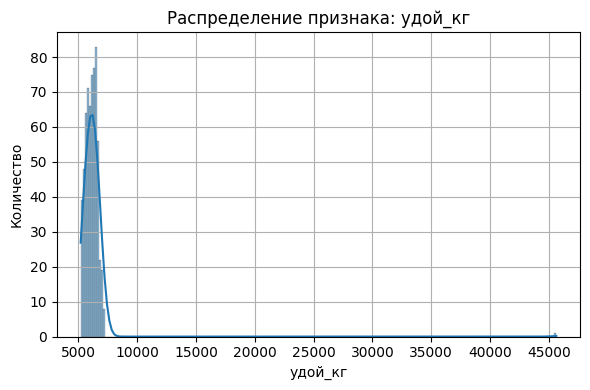

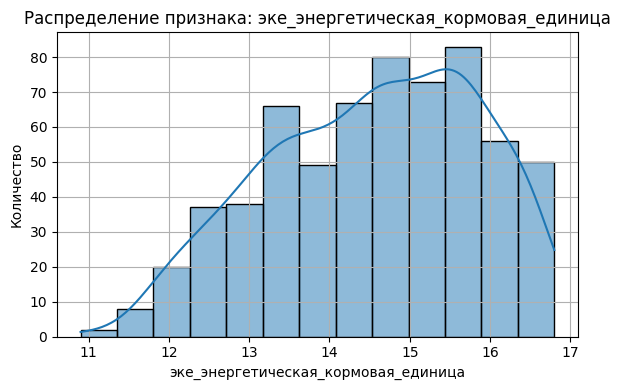

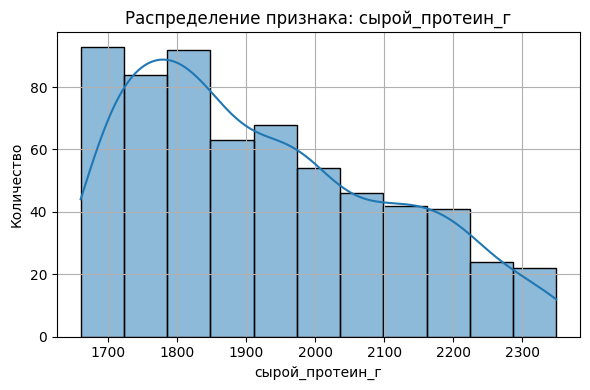

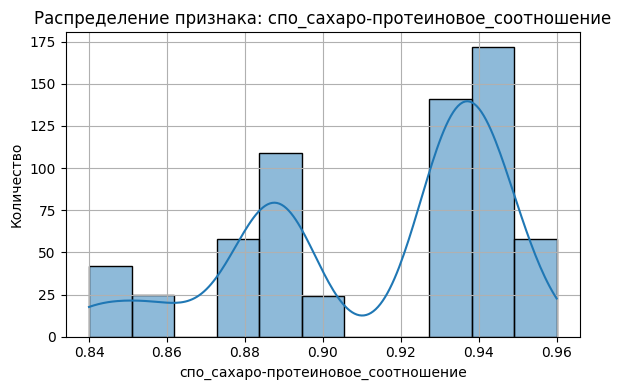

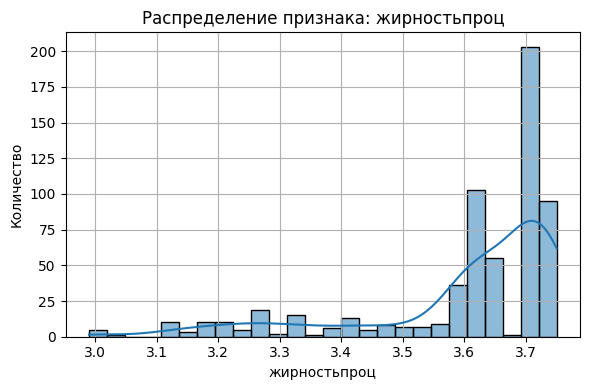

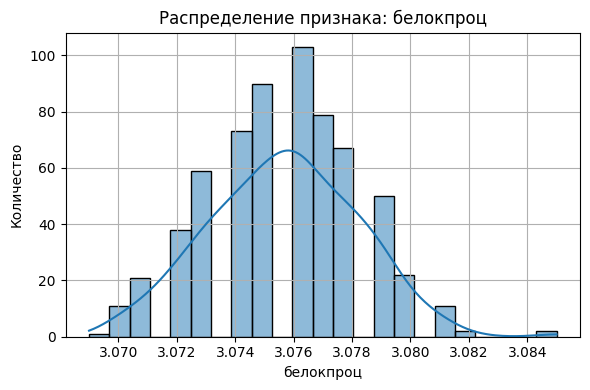


 Частоты значений в признаке 'порода':
порода
вис_бик_айдиал     373
рефлешнсоверинг    256
Name: count, dtype: int64


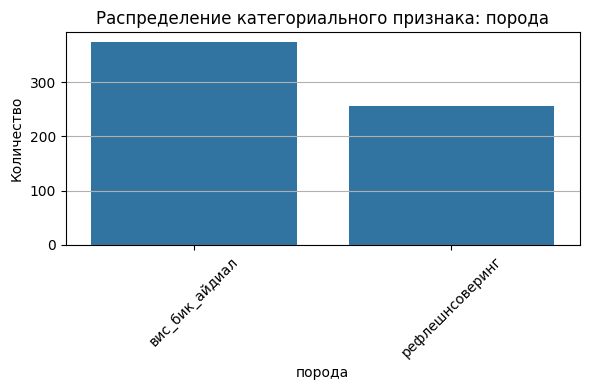


 Частоты значений в признаке 'тип_пастбища':
тип_пастбища
холмистое    351
равнинное    278
Name: count, dtype: int64


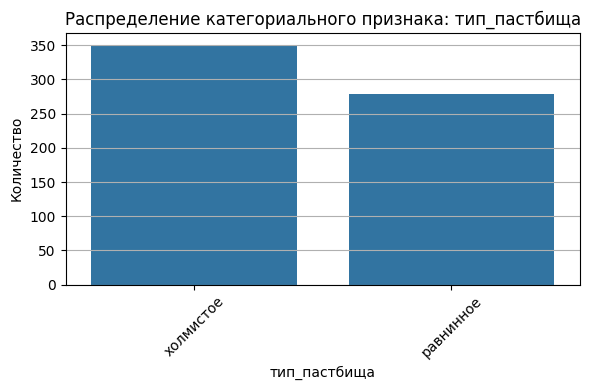


 Частоты значений в признаке 'порода_папы_быка':
порода_папы_быка
айдиал     318
соверин    311
Name: count, dtype: int64


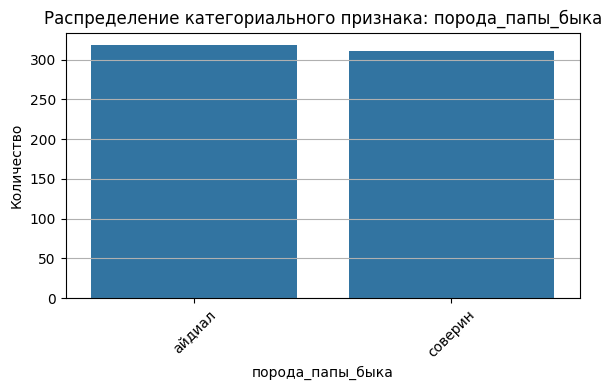


 Частоты значений в признаке 'вкус_молока':
вкус_молока
вкусно       371
не_вкусно    258
Name: count, dtype: int64


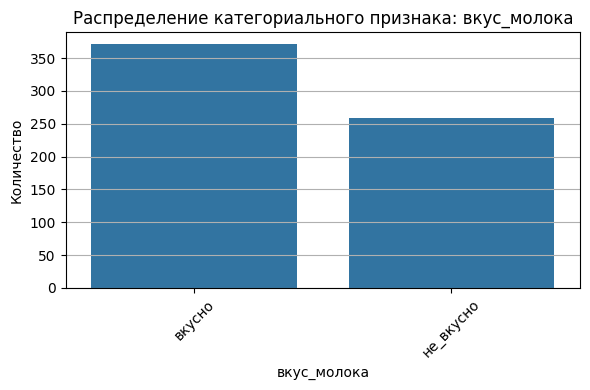


 Частоты значений в признаке 'возраст':
возраст
более_2_лет    519
менее_2_лет    110
Name: count, dtype: int64


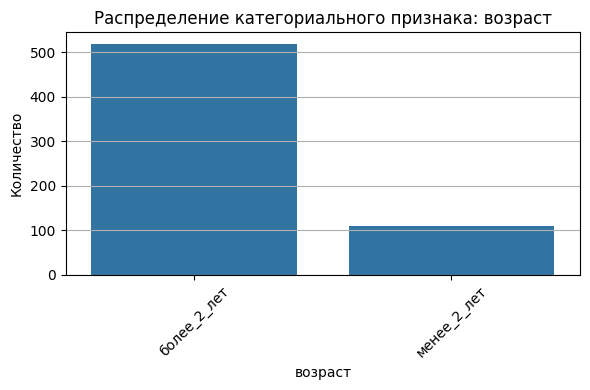

In [ ]:
# Исследование датасета ferma_main

# Определим количественные и категориальные признаки в отдельные переменные
numeric_cols_main = ['удой_кг', 'эке_энергетическая_кормовая_единица',
                'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение',
                'жирностьпроц', 'белокпроц']

categorical_cols_main = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']

# Описательная статистика количественных признаков
print(" Описательная статистика:")
display(ferma_main[numeric_cols_main].describe().T)

# Гистограммы количественных признаков
for col in numeric_cols_main:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=ferma_main, x=col, kde=True)
    plt.title(f"Распределение признака: {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Частоты категориальных признаков
for col in categorical_cols_main:
    print(f"\n Частоты значений в признаке '{col}':")
    print(ferma_main[col].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(data=ferma_main, x=col, order=ferma_main[col].value_counts().index)
    plt.title(f"Распределение категориального признака: {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


**Вывод по статистическому анализу признаков для датасета `ferma_main`**

Количественные признаки:

- `удой_кг`:
  - Среднее значение: ~6189 кг в год.
  - Есть аномально высокие значения — максимум 45616 кг, что сильно выбивается из общего диапазона (верхний квартиль ~6500).
  - Это явный выброс, который следует учесть отдельно (возможно, ошибка ввода).

- `эке_энергетическая_кормовая_единица`:
  - Распределение выглядит близким к нормальному со смещением вправо и длинным хвостом слева.
  - Значения находятся в ожидаемом диапазоне (от ~11 до ~17).

- `сырой_протеин_г`:
  - Выглядит логично, умеренный разброс. Признак потенциально важен.

- `спо_сахаро-протеиновое_соотношение`:
  - Узкий диапазон значений (0.84–0.96), что может затруднить влияние этого признака на модель.
  - Может быть смысл перевести его в категориальный, если наблюдается кластеризация (будем проверять дальше).

- `жирностьпроц` и `белокпроц`:
  - `жирностьпроц` распределена нормально с небольшим разбросом.
  - `белокпроц` — почти постоянная величина (~3.07), возможна переоценка полезности признака для модели.

Категориальные признаки:

- В выборке доминирует одна порода — `вис_бик_айдиал` (373 против 256).
- По пастбищу тоже есть перекос в сторону `холмистое` (351 против 278).
- `порода_папы_быка` почти равномерно распределена между `айдиал` и `соверин`.
- Вкусовые предпочтения смещены в сторону `вкусно`, но выборка сбалансирована (371/258).
- Большая часть коров — старше 2 лет (519 из 629).

---

Что планируется сделать дальше:
- Устранить выброс в `удой_кг`.

In [ ]:
# Сохраняем размерность до удаления
initial_shape = ferma_main.shape

# Удаляем выбросы
ferma_main = ferma_main[ferma_main['удой_кг'] <= 8000].reset_index(drop=True)

# Сохраняем размерность после удаления
final_shape = ferma_main.shape

# Выводим информацию
print(f" Размерность до удаления: {initial_shape}")
print(f" Размерность после удаления: {final_shape}")
print(f" Удалено строк: {initial_shape[0] - final_shape[0]}")


 Размерность до удаления: (629, 12)
 Размерность после удаления: (628, 12)
 Удалено строк: 1


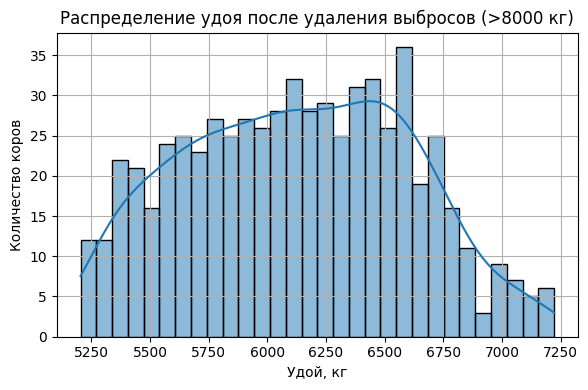

In [ ]:
# Гистограмма 'удой_кг' после удаления выбросов

plt.figure(figsize=(6, 4))
sns.histplot(data=ferma_main, x='удой_кг', kde=True, bins=30)
plt.title("Распределение удоя после удаления выбросов (>8000 кг)")
plt.xlabel("Удой, кг")
plt.ylabel("Количество коров")
plt.grid(True)
plt.tight_layout()
plt.show()

Датасет ferma_dad — общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None


 Уникальные значения в 'имя_папы':


имя_папы
барин       240
буйный      215
соловчик    110
геркулес     64
Name: count, dtype: int64


 Уникальных ID: 629 из 629 строк


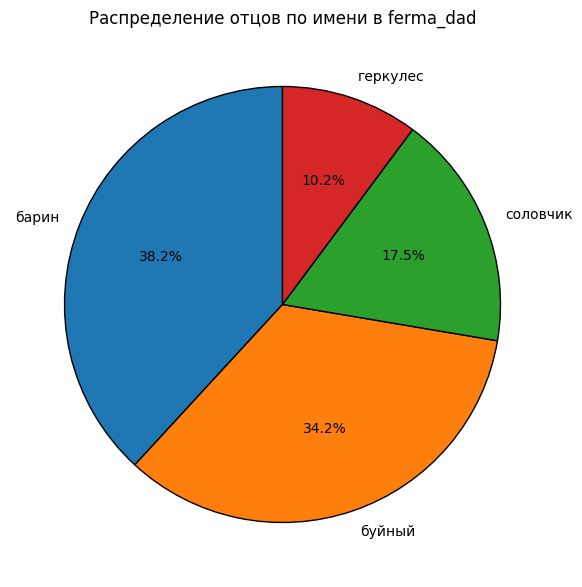

In [ ]:
# Исследование датасета ferma_dad

print("Датасет ferma_dad — общая информация:")
display(ferma_dad.info())
print("\n Уникальные значения в 'имя_папы':")
display(ferma_dad['имя_папы'].value_counts())

# Проверим уникальность id
print(f"\n Уникальных ID: {ferma_dad['id'].nunique()} из {ferma_dad.shape[0]} строк")

# Круговая диаграмма для 'имя_папы'
plt.figure(figsize=(6, 6))
ferma_dad['имя_папы'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)

plt.title("Распределение отцов по имени в ferma_dad")
plt.ylabel("")
plt.tight_layout()
plt.show()


**Вывод по статистическому анализу признаков для датасета `ferma_dad`**

Количественные признаки:
- В датасете `ferma_dad` нет количественных признаков, кроме `id`, который является уникальным идентификатором (629 уникальных значений из 629 строк). Он не участвует в анализе как числовой признак.

Категориальные признаки:
- Признак `имя_папы` содержит 4 уникальных значения:
  - `барин` — встречается чаще всего (240 раз),
  - затем идут `буйный` (215), `соловчик` (110) и `геркулес` (64).
- Распределение относительно сбалансировано, однако наблюдается небольшое доминирование отцов `барин` и `буйный` - они являются отцами для 72% коров.


Что планируется сделать далее:
- Данные выглядят нормально, без явных выбросов, пропусков или аномалий. Предобработка выполнена успешно, можно переходить к следующему шагу.

 Датасет cow_buy — общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   порода                     16 non-null     object 
 1   тип_пастбища               16 non-null     object 
 2   порода_папы_быка           16 non-null     object 
 3   имя_папы                   16 non-null     object 
 4   текущая_жирностьпроц       16 non-null     float64
 5   текущий_уровень_белокпроц  16 non-null     float64
 6   возраст                    16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


None


 Описательная статистика по числовым признакам:


count      mean       std    min     25%     50%  \
текущая_жирностьпроц        16.0  3.571875  0.141620  3.340  3.4150  3.5850   
текущий_уровень_белокпроц   16.0  3.068250  0.011264  3.046  3.0595  3.0735   

                               75%    max  
текущая_жирностьпроц       3.69250  3.770  
текущий_уровень_белокпроц  3.07675  3.081

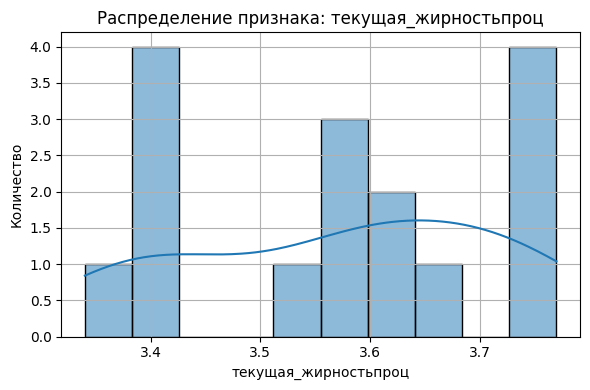

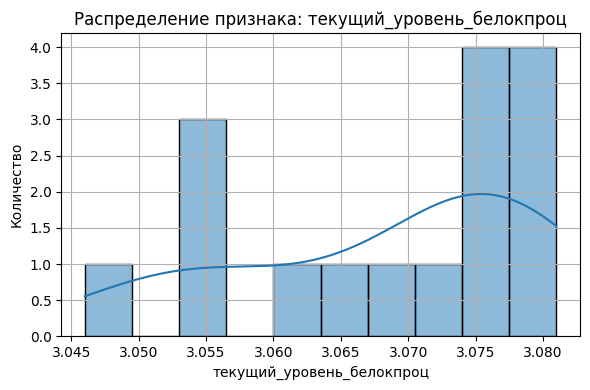


 Частоты значений в признаке 'порода':
порода
вис_бик_айдиал     8
рефлешнсоверинг    8
Name: count, dtype: int64


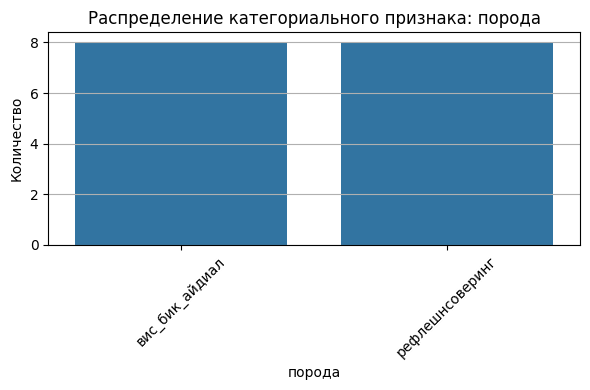


 Частоты значений в признаке 'тип_пастбища':
тип_пастбища
холмистое    8
равнинное    8
Name: count, dtype: int64


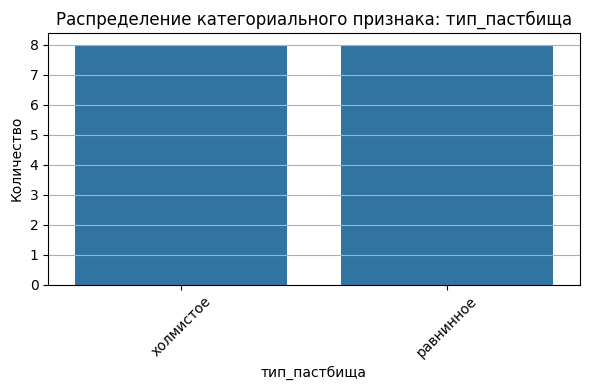


 Частоты значений в признаке 'порода_папы_быка':
порода_папы_быка
соверин    10
айдиал      6
Name: count, dtype: int64


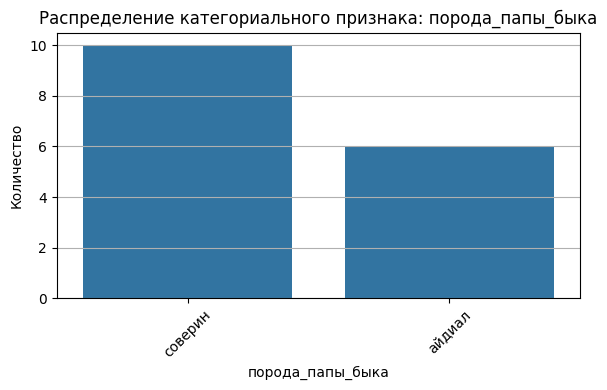


 Частоты значений в признаке 'имя_папы':
имя_папы
буйный      7
геркулес    5
барин       2
соловчик    2
Name: count, dtype: int64


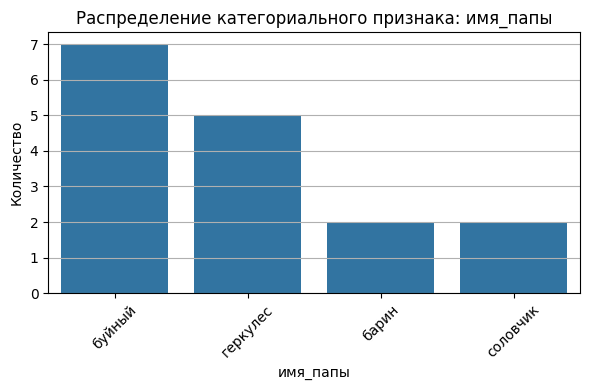


 Частоты значений в признаке 'возраст':
возраст
более_2_лет    11
менее_2_лет     5
Name: count, dtype: int64


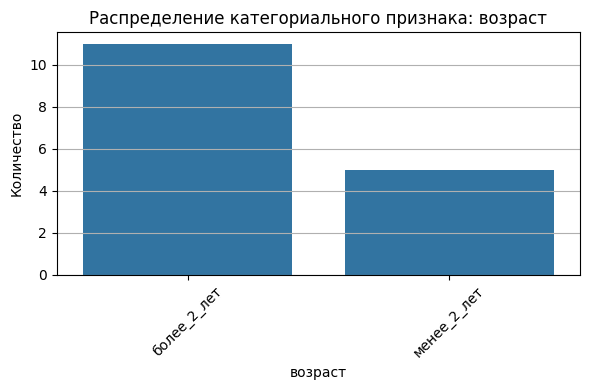

In [ ]:
# Исследование датасета cow_buy
print(" Датасет cow_buy — общая информация:")
display(cow_buy.info())

# Разделим признаки на числовые и категориальные
numeric_cols_cow = ['текущая_жирностьпроц', 'текущий_уровень_белокпроц']
categorical_cols_cow = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст']

# Статистика по числовым
print("\n Описательная статистика по числовым признакам:")
display(cow_buy[numeric_cols_cow].describe().T)

# Гистограммы числовых признаков
for col in numeric_cols_cow:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=cow_buy, x=col, kde=True, bins=10)
    plt.title(f"Распределение признака: {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Частоты категориальных признаков
for col in categorical_cols_cow:
    print(f"\n Частоты значений в признаке '{col}':")
    print(cow_buy[col].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(data=cow_buy, x=col, order=cow_buy[col].value_counts().index)
    plt.title(f"Распределение категориального признака: {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

**Вывод по статистическому анализу признаков для датасета `cow_buy`**

Количественные признаки:

- `текущая_жирностьпроц` варьируется от 3.34 до 3.77, среднее значение — 3.57. Распределение умеренно скошено вправо, разброс — нормальный.
- `текущий_уровень_белокпроц` имеет очень узкий диапазон (от 3.046 до 3.081) и крайне низкое стандартное отклонение (~0.01), что говорит о **почти постоянной** величине. Этот признак может иметь **низкую информативность** для модели.


Категориальные признаки:

- Признаки `порода` и `тип_пастбища` распределены **поровну** — по 8 значений каждой категории.
- `порода_папы_быка` распределена неравномерно: преобладает `соверин` (10 из 16).
- `имя_папы` встречаются 4 уникальных имени, без явного доминирования.
- По возрасту преобладают **коровы старше 2 лет** (11 из 16).

Что планируется сделать далее:

- Данные выглядят нормально, без явных выбросов, пропусков или аномалий. Предобработка выполнена успешно, можно переходить к следующему шагу.

**Как можно улучшить данные:**

`ferma_main`:
- Проверить нелинейные зависимости по `спо` и `эке`, возможно ввести новые признаки.
- Рассмотреть бинаризацию `спо`, если подтвердится кластеризация.
- Признак `белокпроц`, возможно, не будет полезен из-за низкой вариативности — проверим его вклад при построении модели.

`ferma_dad`:
- Проверить, оказывает ли `имя_папы` влияние на целевые признаки — возможно, есть скрытые зависимости.

`cow_buy`:
- Признаки `жирность` и `белок` имеют низкую дисперсию, но могут нести ценность - проверим их влияние в будущем.
- Провести финальное кодирование категориальных признаков, чтобы использовать их при прогнозировании.


**Общий вывод**

По результатам статистического анализа можно сделать вывод, что данные:
- не содержат пропусков / дубликатов;
- логично структурированы;
- прошли успешную очистку и нормализацию;
- содержат потенциально значимые признаки для построения моделей машинного обучения.

Все три датасета готовы к следующему этапу — **корреляционному анализу и подготовке входных признаков к моделированию**.

#### 4. Корреляционный анализ / Correlation analysis


🔷 **Data sidenote**

The correlation analysis of the main dataset highlighted several key insights:  

- Strong correlations: Milk yield is highly correlated with the sugar–protein ratio (0.81) and feed energy (0.77). These two predictors are also strongly correlated with each other, suggesting multicollinearity.  
- Moderate correlations: Yield has a meaningful positive relationship with fat content (0.60) and feed protein (0.45).  
- Weak/insignificant correlations: Milk protein percentage shows virtually no correlation with yield or other predictors, reducing its value for modeling.  
- Subgroup effects: Scatterplots by breed, pasture type, sire, taste, and age confirm patterns. Age is a critical factor — older cows consistently yield more milk with higher nutritional values. Breed and sire show moderate effects on feed-related indicators, while taste preferences have only weak associations.  

**Conclusions:**  
- The most promising predictors are the sugar–protein ratio, feed energy, and fat content.  
- Multicollinearity between feed-related variables should be addressed during modeling.  
- Milk protein percentage can be excluded or treated as a low-priority feature.  
- Polynomial or interaction terms may help capture nonlinear effects and subgroup differences.  

🔶 **Code sidenote**  

The correlation analysis was implemented with:  
- Pearson correlation matrix and heatmap to measure and visualize pairwise relationships;  
- Scatterplots with regression lines, grouped by categorical attributes (breed, pasture type, sire, taste, age), to detect subgroup effects;  
- Overlayed correlation coefficients for clarity and quantitative reference.  

This approach efficiently surfaces strong predictors, highlights risks of multicollinearity, and informs feature engineering strategies for robust modeling.

---

 Проведем корреляционный анализ признаков в датасете 'ferma_main.csv', построим диаграммы рассеяния целевого ('Удой, кг') и остальных количественных признаков с учётом значения категориальных признаков с учетом характера связей в подгруппах.

В ходе корр анализа сформируем выводы по следующим вопросам:
- Какой тип взаимосвязи между целевым и входными признаками?
- Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?
- Наблюдается ли мультиколлинеарность между входными признаками?

In [ ]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   628 non-null    int64  
 1   удой_кг                              628 non-null    int64  
 2   эке_энергетическая_кормовая_единица  628 non-null    float64
 3   сырой_протеин_г                      628 non-null    int64  
 4   спо_сахаро-протеиновое_соотношение   628 non-null    float64
 5   порода                               628 non-null    object 
 6   тип_пастбища                         628 non-null    object 
 7   порода_папы_быка                     628 non-null    object 
 8   жирностьпроц                         628 non-null    float64
 9   белокпроц                            628 non-null    float64
 10  вкус_молока                          628 non-null    object 
 11  возраст                         

In [ ]:
# Расчёт и вывод корреляционной матрицы

corr_matrix_main = ferma_main[numeric_cols_main].corr(method='pearson')
display(corr_matrix_main)

удой_кг  \
удой_кг                              1.000000   
эке_энергетическая_кормовая_единица  0.765098   
сырой_протеин_г                      0.446731   
спо_сахаро-протеиновое_соотношение   0.806339   
жирностьпроц                         0.600902   
белокпроц                            0.002966   

                                     эке_энергетическая_кормовая_единица  \
удой_кг                                                         0.765098   
эке_энергетическая_кормовая_единица                             1.000000   
сырой_протеин_г                                                 0.387875   
спо_сахаро-протеиновое_соотношение                              0.749007   
жирностьпроц                                                    0.637279   
белокпроц                                                      -0.008939   

                                     сырой_протеин_г  \
удой_кг                                     0.446731   
эке_энергетическая_кормовая_единица         0.387875   
сырой_протеин_г                             1.000000   
спо_сахаро-протеиновое_соотношение          0.446332   
жирностьпроц                                0.357793   
белокпроц                                   0.226802   

                                     спо_сахаро-протеиновое_соотношение  \
удой_кг                                                        0.806339   
эке_энергетическая_кормовая_единица                            0.749007   
сырой_протеин_г                                                0.446332   
спо_сахаро-протеиновое_соотношение                             1.000000   
жирностьпроц                                                   0.629098   
белокпроц                                                      0.073718   

                                     жирностьпроц  белокпроц  
удой_кг                                  0.600902   0.002966  
эке_энергетическая_кормовая_единица      0.637279  -0.008939  
сырой_протеин_г                          0.357793   0.226802  
спо_сахаро-протеиновое_соотношение       0.629098   0.073718  
жирностьпроц                             1.000000  -0.026542  
белокпроц                               -0.026542   1.000000

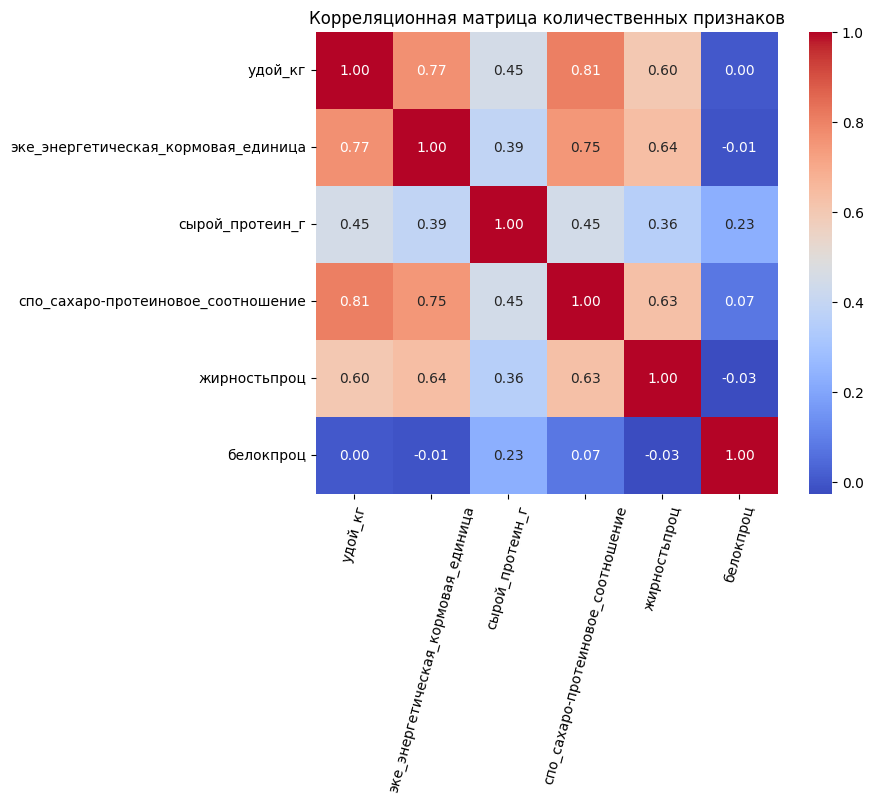

In [ ]:
# Визуализация корреляционной матрицы

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_main, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Корреляционная матрица количественных признаков")
plt.xticks(rotation=75)
plt.show()

**Корреляционный анализ признаков (`ferma_main`)**:

На основе матрицы корреляций (метод Пирсона) проанализированы взаимосвязи между числовыми признаками. Для оценки силы связи использовалась шкала Чеддока.

1. Признаки с высокой корреляцией (0.7 – 0.9)

| Пара признаков                                       | Коэффициент | Комментарий |
|------------------------------------------------------|-------------|-------------|
| `удой_кг` ↔ `спо_сахаро-протеиновое_соотношение`     | **0.806**   | Выраженная мультиколлинеарность |
| `удой_кг` ↔ `эке_энергетическая_кормовая_единица`    | **0.765**   | Умеренная/заметная мультиколлинеарность |
| `спо` ↔ `эке`                                         | **0.749**   | Умеренная/заметная мультиколлинеарность |

---

2. Признаки с заметной корреляцией (0.5 – 0.7)

| Пара признаков                   | Коэффициент |
|----------------------------------|-------------|
| `удой_кг` ↔ `жирностьпроц`       | 0.601       |
| `эке` ↔ `жирностьпроц`           | 0.637       |
| `спо` ↔ `жирностьпроц`           | 0.629       |

- Эти признаки положительно связаны с продуктивностью и качеством молока.

---

3. Признаки со средней корреляцией (0.3 – 0.5)

| Пара признаков                     | Коэффициент |
|------------------------------------|-------------|
| `удой_кг` ↔ `сырой_протеин_г`      | 0.447       |
| `сырой_протеин_г` ↔ `спо`          | 0.446       |
| `сырой_протеин_г` ↔ `жирностьпроц` | 0.358       |

- Белковая составляющая корма также оказывает влияние, но менее выраженное.

---

4. Признаки со слабой корреляцией (0.1 – 0.3)

| Пара признаков                  | Коэффициент |
|---------------------------------|-------------|
| `сырой_протеин_г` ↔ `белокпроц` | 0.227       |

---

5. Очень слабая или отсутствующая корреляция (0 – 0.1)

| Пара признаков              | Коэффициент |
|-----------------------------|-------------|
| `удой_кг` ↔ `белокпроц`      | 0.003       |
| `эке` ↔ `белокпроц`          | -0.009      |
| `спо` ↔ `белокпроц`          | 0.074       |
| `жирностьпроц` ↔ `белокпроц` | -0.027      |

- Признак `белокпроц` не связан с другими признаками — его информативность под вопросом.

---

**Вывод по корреляционному анализу признаков**:

- **Ключевыми признаками** для прогнозирования `удой_кг` являются `спо`, `эке` и `жирностьпроц`.
- Между `спо` и `эке` наблюдается **высокая корреляция**, возможна мультиколлинеарность — следует учесть при моделировании.
- Признак `белокпроц` можно **удалить или протестировать отдельно**, так как он практически не коррелирует с целевой переменной.



🎨 Группировка по признаку: порода


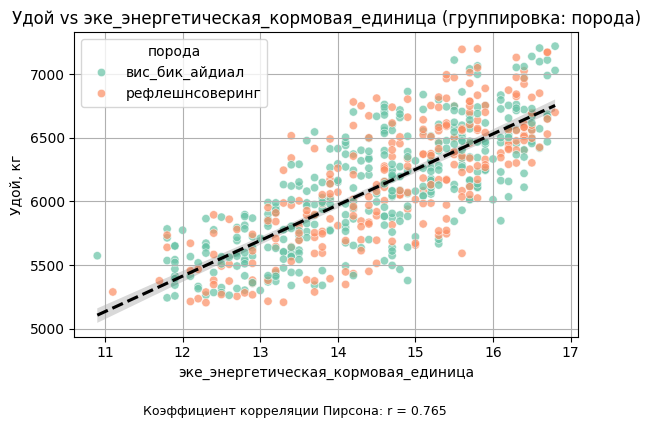

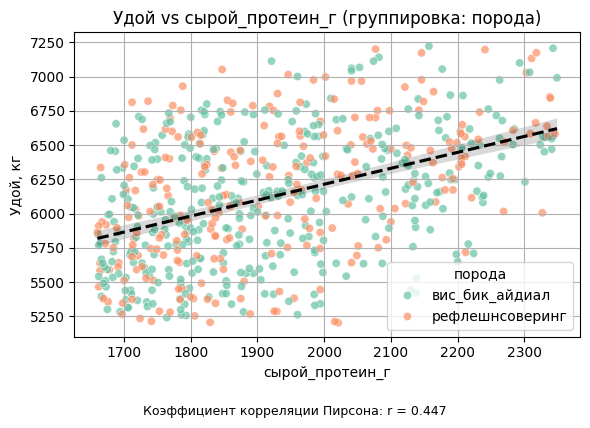

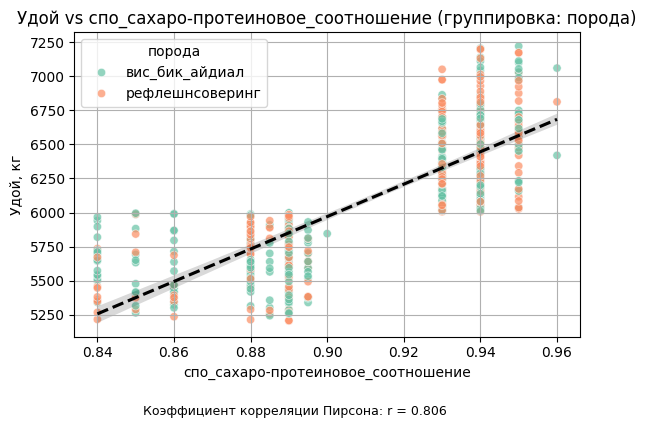

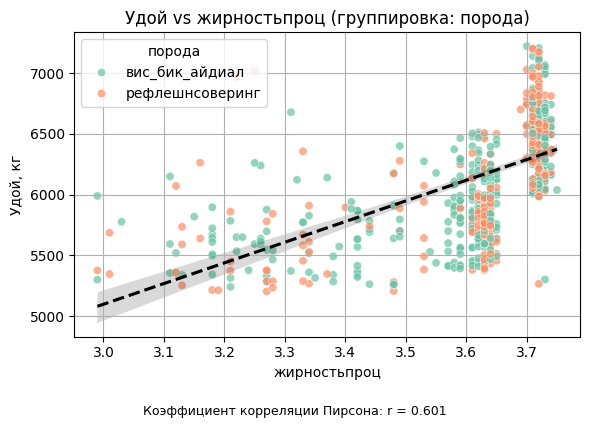

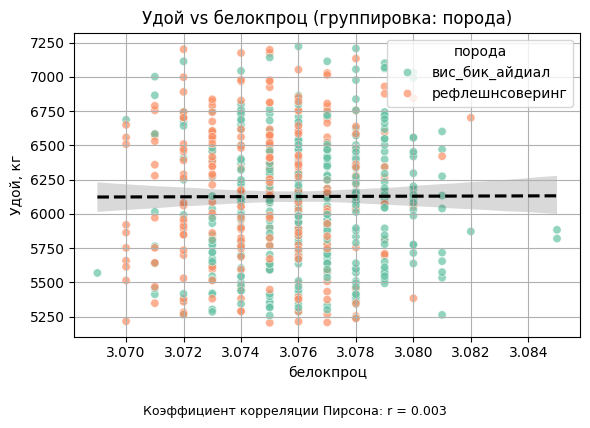


🎨 Группировка по признаку: тип_пастбища


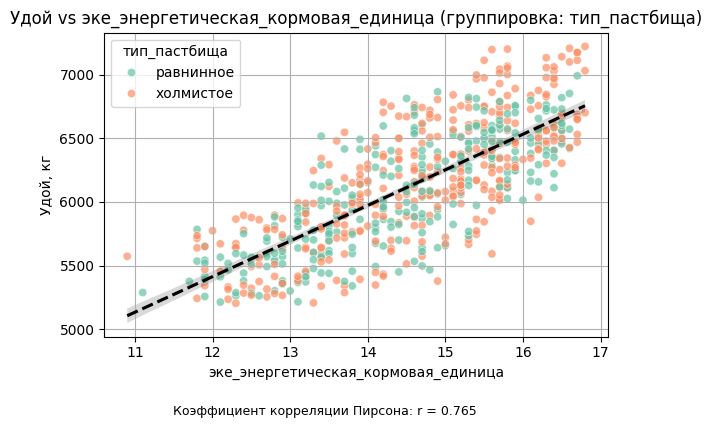

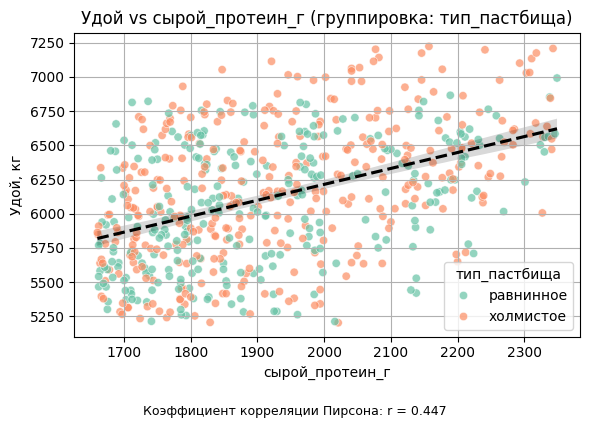

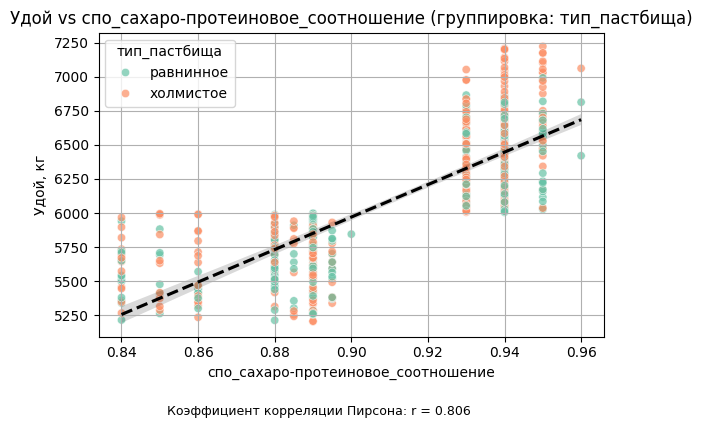

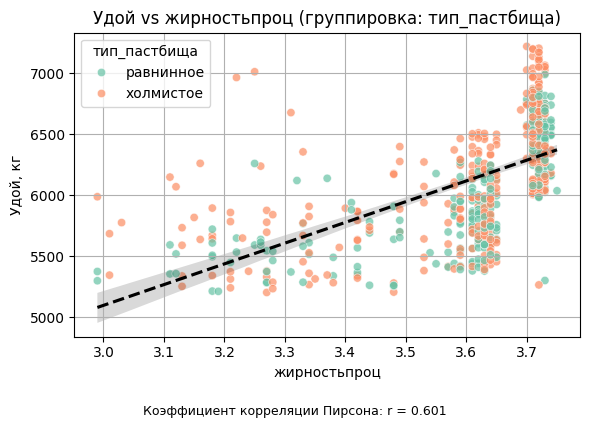

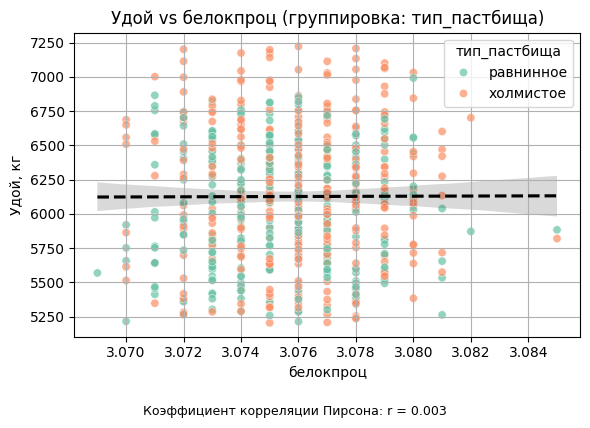


🎨 Группировка по признаку: порода_папы_быка


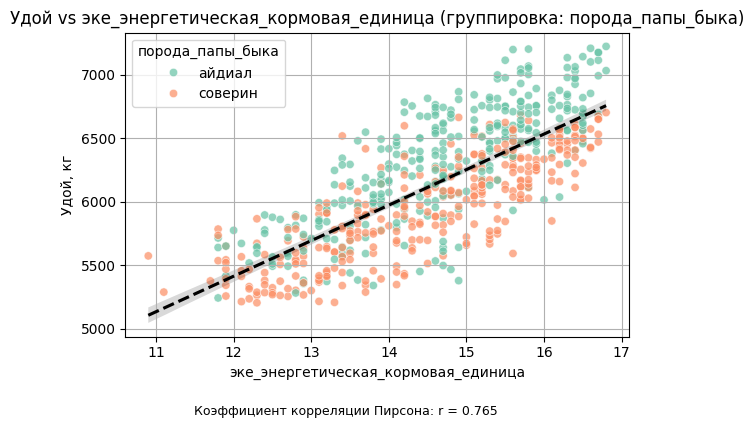

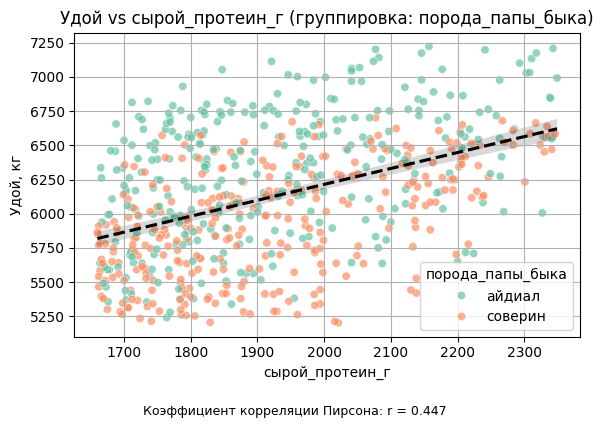

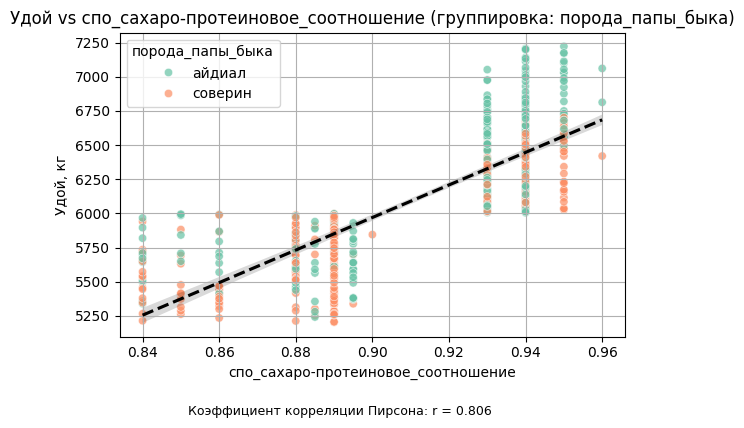

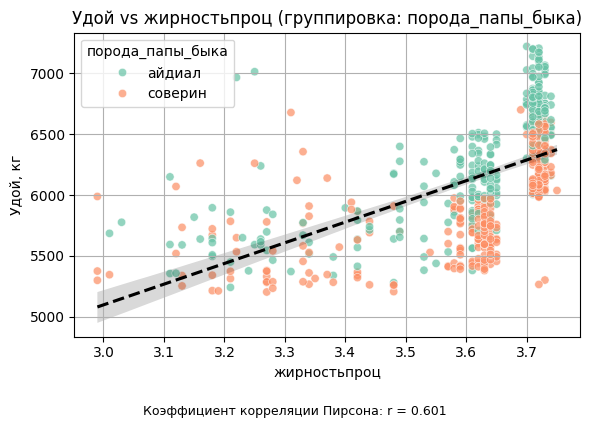

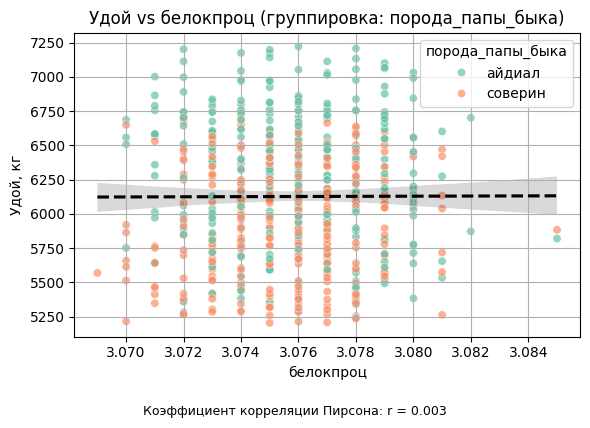


🎨 Группировка по признаку: вкус_молока


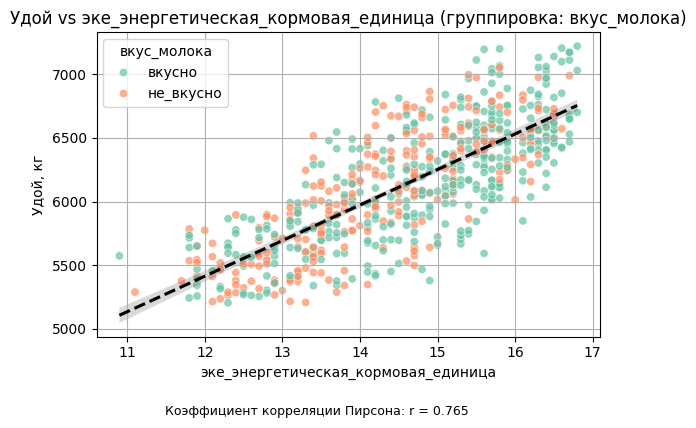

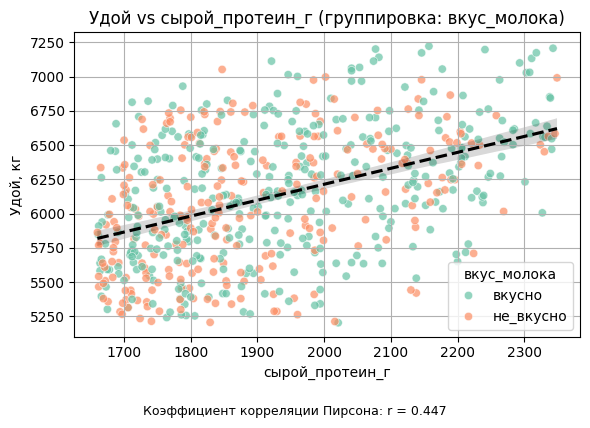

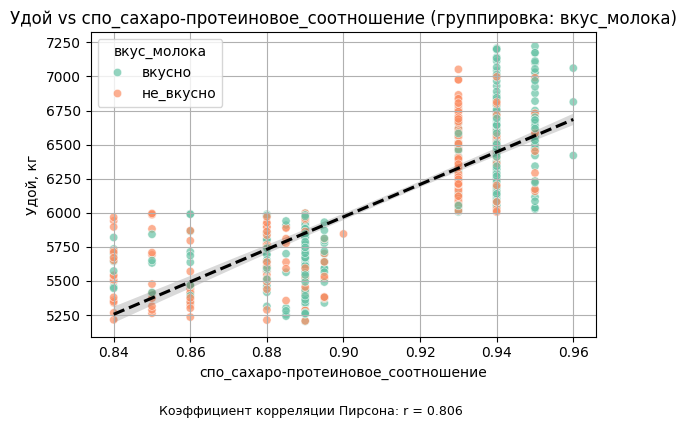

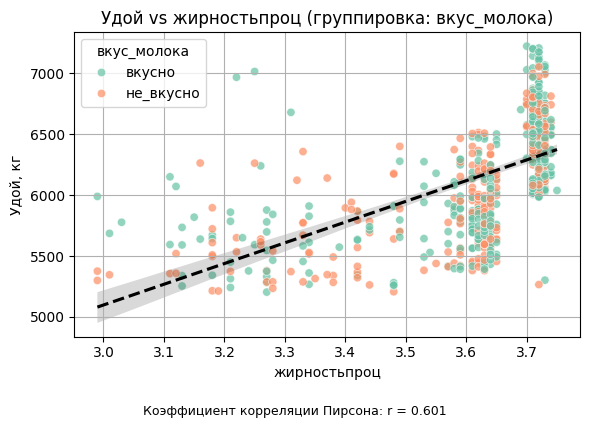

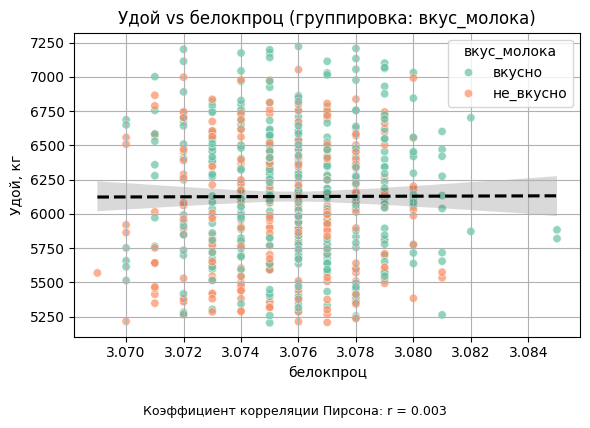


🎨 Группировка по признаку: возраст


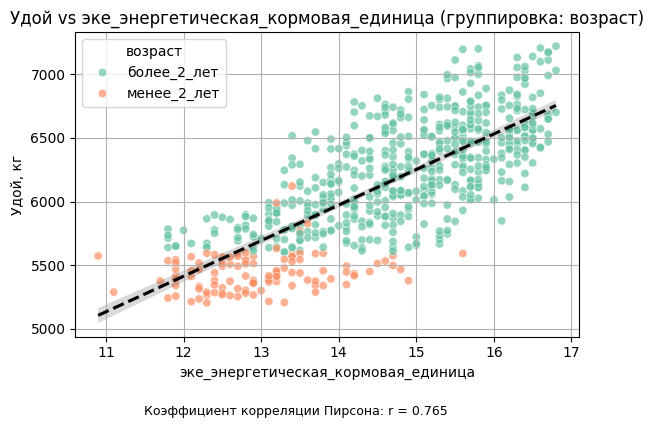

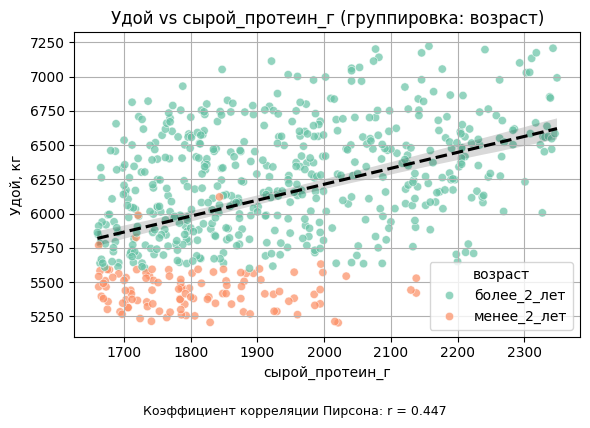

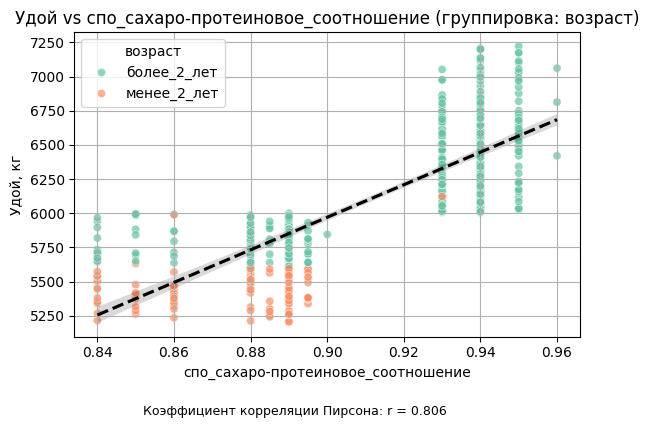

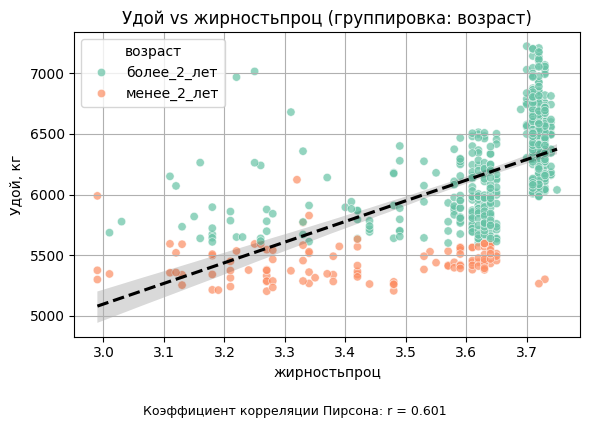

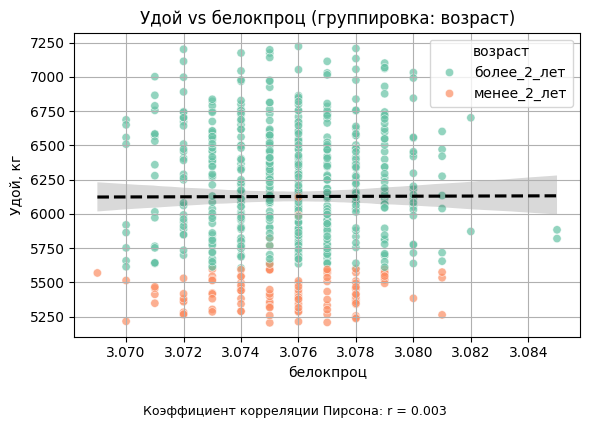

In [ ]:
# Количественные признаки (кроме целевого)
numeric_features = ['эке_энергетическая_кормовая_единица',
                    'сырой_протеин_г',
                    'спо_сахаро-протеиновое_соотношение',
                    'жирностьпроц',
                    'белокпроц']

# Категориальные признаки, по которым группируем точки по цвету
hue_options = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']

# Строим графики
for hue_col in hue_options:
    print(f"\n🎨 Группировка по признаку: {hue_col}")
    for num_col in numeric_features:
        # Вычисляем коэффициент корреляции (Pearson)
        corr_coef, p_value = pearsonr(ferma_main[num_col], ferma_main['удой_кг'])

        # Строим график
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=ferma_main,
                        x=num_col,
                        y='удой_кг',
                        hue=hue_col,
                        palette='Set2',
                        alpha=0.7)

        # Линия регрессии
        sns.regplot(data=ferma_main,
                    x=num_col,
                    y='удой_кг',
                    scatter=False,
                    color='black',
                    line_kws={'linestyle': 'dashed'})

        plt.title(f"Удой vs {num_col} (группировка: {hue_col})")
        plt.xlabel(num_col)
        plt.ylabel("Удой, кг")
        plt.legend(title=hue_col)
        plt.grid(True)
        plt.tight_layout()

        # Добавим подпись с корреляцией
        plt.figtext(0.5, -0.05, f"Коэффициент корреляции Пирсона: r = {corr_coef:.3f}", ha='center', fontsize=9)
        plt.show()

**Влияние количественных признаков на удой (удой_кг)**

1. По признаку `порода`:

эке_энергетическая_кормовая_единица:

- Коэффициент корреляции: 0.765 - Умеренная/заметная мультиколлинеарность
- Сильная линейная связь.
- Точки группируются вдоль линии тренда, без заметных различий между породами.

сырой_протеин_г:

- Коэффициент корреляции: 0.447
- Умеренная положительная связь.
- Заметен разброс, особенно у породы вис_бик_айдиал.

спо_сахаро-протеиновое_соотношение:

- Коэффициент корреляции: 0.806 - Выраженная мультиколлинеарность
- Сильная линейная связь.
- Связь устойчива для обеих пород.
- Значения целевой переменной резко меняются при пересечении определенного значения СПО, это может говорить о наличии категорий в признаке.

жирностьпроц:

- Коэффициент корреляции: 0.600
- Умеренная связь.
- У породы рефлешнсоверинг жирность чуть выше.

белокпроц:

- Коэффициент корреляции: 0.003
- Связь отсутствует.
- Облако точек без направления, не рекомендуется к включению в модель.

2. По признаку `тип_пастбища`:

- Влияние на удой_кг не прослеживается.
- Равнинное и холмистое пастбища не формируют устойчивые кластеры.

3. По признаку `порода_папы_быка`:

- У потомков быков айдиал выше значения питательности кормовой базы, а у выводка от них выше влияющие на вкус молока показатели: эке, спо, жирностьпроц, белокпроц.
- Возможна полезность при введении взаимодействий в модели.

4. По признаку `вкус_молока`:

- Сильной связи между удой_кг и вкусом нет.

Однако:

- При более высоком спо чаще встречается вкусное молоко.

- Жирностьпроц также чуть выше у вкусного молока.

- Белокпроц не влияет на вкус.

5. По признаку `возраст`:

Коровы старше 2 лет:

- Производят больше удоя
- Имеют выше: протеин, спо, жирностьпроц, белокпроц
- Возраст — важный фактор. Можно бинаризовать (0/1).

**Выводы по диаграммам рассеивания:**

1. Наиболее полезные признаки:

- спо_сахаро-протеиновое_соотношение

- эке_энергетическая_кормовая_единица

- жирностьпроц

2. Малополезные:

- белокпроц — практически не даёт дополнительной информации

**Рекомендации:**

В дальнейшем, при моделировании, стоит так же вниматльно следить за признаками и их значимостью, исключать возможную мультиколлениальность, масштарибровать и кодировать признаки для более точного обучения линейных моделей. Так же можно рассмотреть введение полиномиальных признаков.


**Выводы о взаимосвязи признаков**:

1. Какой тип взаимосвязи между целевым и входными признаками?

- Между целевым признаком удой_кг и большинством количественных признаков наблюдается линейные и нелинейные положительные связи.

- Наиболее сильные корреляции: спо_сахаро-протеиновое_соотношение, эке_энергетическая_кормовая_единица и жирностьпроц.

2. Есть ли нелинейные связи между целевым и входными признаками?

Большиство важных признаков имеют линейную, так и нелинейную зависимость, однако так же прослеживаются паттерны, свидетельсвующие о мультиколлениальности, что увеличивает шанс введения дополнительных признаков при обучении модели.

3. Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?

Рекомендуется рассмотреть возможность введения полиномилальных признаков в дальнейшем.

#### 5. Обучение модели линейной регрессии / Training a linear regression model

🔷 **Data sidenote**

Three linear regression models were trained and compared. Model 1 used standard preprocessing and reached R² = 0.796. Model 2 added SPO binarization and squared feed energy, improving to R² = 0.820. Model 3 added sire name and achieved R² = 0.833, the best result. Residuals in all models were near-normal, centered on zero, with Model 3 showing the tightest distribution and least bias. Error metrics (MSE, MAE, RMSE) confirmed steady improvement. A 90% confidence interval for Model 3 residuals was about -328 to +284 kg, meaning predictions around 6200 kg fall within 5872–6484 kg. Forecasts for new cows were generated after imputing feed attributes with farm averages increased by 5%.

🔶 **Code sidenote**

Data was split into train/test. Numeric features were scaled, categorical features one-hot encoded, combined with ColumnTransformer. Model 2 engineered SPO as binary and squared feed energy. Model 3 merged sire name from another dataset. Models were trained with LinearRegression, evaluated using R², MSE, MAE, RMSE, and diagnostic plots (Fact vs Pred, Residuals hist, Residuals vs Pred). Forecasts for new cows reused the trained preprocessing and Model 3.

---

5.1 Подготовим данные датасета ferma_main.csv и обучим на них первую модель LinearRegression.

- В качестве признаков выбираю те, что связаны с удоем по корреляции и причинно-следственным связям.

- Данные делю на тренировочную и тестовую выборки.

- Категориальные признаки кодирую с помощью OneHotEncoder.

- Количественные признаки масштабирую с помощью StandardScaler.

- Обучаю модель линейной регрессии на подготовленных данных.

- Качество оцениваю по R² и анализу остатков на графиках.

- В выводах указываю значение R², интерпретацию остатков и необходимость дополнительных исследований.

In [ ]:
# Числовые признаки
numeric_features_1 = [
    'эке_энергетическая_кормовая_единица',
    'спо_сахаро-протеиновое_соотношение',
    'жирностьпроц',
    'сырой_протеин_г'
]

# Категориальные признаки
categorical_features_1 = [
    'порода',
    'тип_пастбища',
    'порода_папы_быка',
    'возраст'
]

# Разделяем X и y
X = ferma_main[numeric_features_1 + categorical_features_1]
y = ferma_main['удой_кг']

RANDOM_STATE = 42

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [ ]:
# Кодируем категориальные признаки с помощью OneHotEncoder
# Масштабируйте количественные признаки с помощью StandardScaler
numeric_transformer_1 = StandardScaler()
categorical_transformer_1 = OneHotEncoder(drop='first')

# Объединение в ColumnTransformer
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_1, numeric_features_1),
        ('cat', categorical_transformer_1, categorical_features_1)
    ]
)

# Преобразование данных
X_train_preprocessed_1 = preprocessor_1.fit_transform(X_train_1)
X_test_preprocessed_1 = preprocessor_1.transform(X_test_1)

In [ ]:
# Обучаем модель на подготовленных данных
model_1 = LinearRegression()
model_1.fit(X_train_preprocessed_1, y_train_1)

# Предсказываем на тестовой выборке
y_pred_1 = model_1.predict(X_test_preprocessed_1)

# Оцениваем качество модели (R²)
r2_1 = r2_score(y_test_1, y_pred_1)
print(f" R² модели 1 на тестовой выборке: {r2_1:.4f}")


 R² модели 1 на тестовой выборке: 0.7960


R² на тестовой выборке: 0.7960 — это значит, что почти 80% дисперсии удоя объясняется моделью, построенной на выбранных признаках.

581    -69.967128
591     82.091451
550   -109.411267
213    -65.926400
485   -311.205155
          ...    
535    -37.600442
319     27.976388
218   -247.099520
344     -9.295823
383   -162.254889
Name: удой_кг, Length: 126, dtype: float64


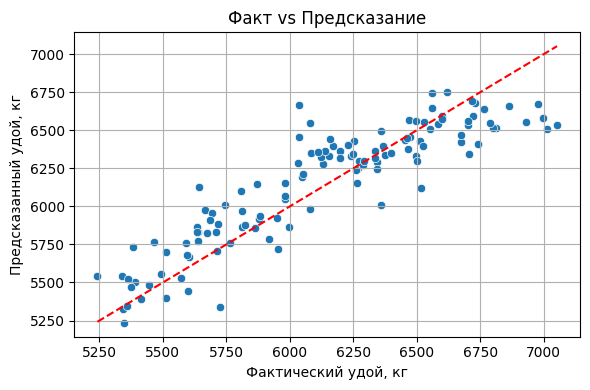

In [ ]:
# Вычисляем остатки
residuals_1 = y_test_1 - y_pred_1
print(residuals_1)

# График: предсказания vs настоящие значения

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test_1, y=y_pred_1)
plt.plot([y_test_1.min(), y_test_1.max()], [y_test_1.min(), y_test_1.max()], '--', color='red')
plt.title("Факт vs Предсказание")
plt.xlabel("Фактический удой, кг")
plt.ylabel("Предсказанный удой, кг")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод по графику Факт vs Предсказание (y_test vs y_pred)**

Сравнивает фактические значения y_test и предсказанные моделью значения y_pred.
Красная пунктирная линия — это идеальный прогноз (где факт = прогноз). Чем ближе точки к этой линии, тем точнее модель.

Большинство точек хорошо группируются вдоль линии. Модель достаточно точно предсказывает удой.
Рассеяние симметрично — признак хорошей аппроксимации.

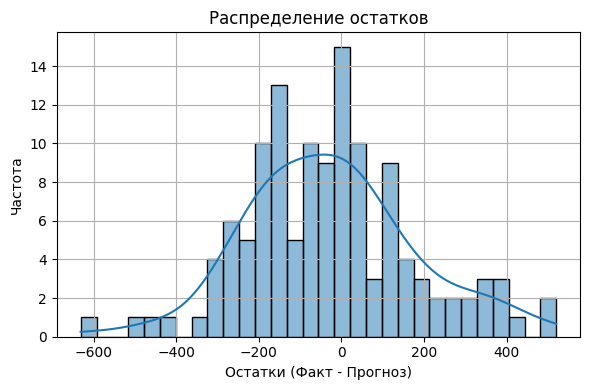

In [ ]:
# График: распределение остатков

plt.figure(figsize=(6, 4))
sns.histplot(residuals_1, bins=30, kde=True)
plt.title("Распределение остатков")
plt.xlabel("Остатки (Факт - Прогноз)")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод по графику гистограммы остатков (residuals = y_test - y_pred)**

Распределение ошибок модели (разница между фактическими и предсказанными значениями).

Если модель хорошо обучена, остатки должны быть распределены нормально (симметрично относительно 0).

Распределение остатков похоже на колокол — близко к нормальному распределению, центрируется около 0.
Небольшой правый хвост указывает на редкие недопредсказания.

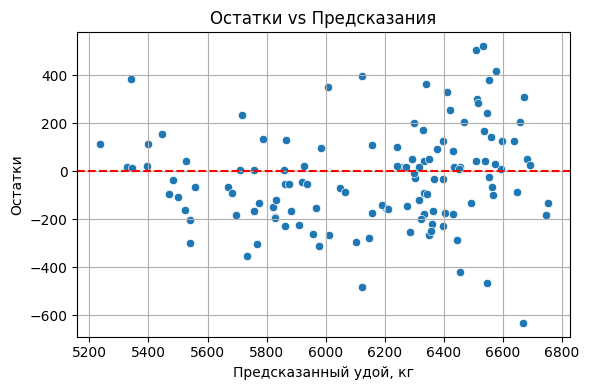

In [ ]:
# График: остатки vs предсказания

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_1, y=residuals_1)
plt.axhline(0, color='red', linestyle='--')
plt.title("Остатки vs Предсказания")
plt.xlabel("Предсказанный удой, кг")
plt.ylabel("Остатки")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод по графику Остатки vs Предсказания (residuals vs y_pred)**

Демнострирует, есть ли систематические ошибки модели, которые зависят от предсказанных значений.

Если модель линейная, и предпосылки выполнены — точки должны быть хаотично разбросаны вокруг горизонтальной линии y=0.

Точки достаточно равномерно разбросаны вокруг нуля, систематической ошибки не видно.
Но у предсказаний ближе к 6700–6800 кг можно заметить немного больший разброс остатков — возможно, модель чуть хуже работает на самых высоких значениях удоя. Это можно исследовать дальше.

**Вывод по подшагу 5.1**:

Все 3 графика подтверждают, что предпосылки линейной регрессии в целом соблюдены:

- Линейность,

- Нормальность остатков,

- Отсутствие неравномерности дисперсии ошибок.

5.2 Подготовим данные с учётом связи входных признаков с целевым и обучим на них вторую модель LinearRegression.

Ранее мы обнаружили, что СПО и Удой связаны нелинейно.
На их диаграмме рассеяния наблюдения сгруппированы
в два кластера, причём есть такое значение СПО,
которое можно считать границей между кластерами.
Чтобы устранить нелинейность, преобразуем СПО
в категориальный бинарный признак, использовав эту границу.

In [ ]:
# Создаем копию данных, чтобы не повредить оригинальный DataFrame

ferma_main_copy = ferma_main.copy()

In [ ]:
#  Преобразование признаков
# 1. Бинаризация SPO через пороговое значение

ferma_main_copy['спо_кат'] = (ferma_main_copy['спо_сахаро-протеиновое_соотношение'] > 0.915).astype(int)

In [ ]:
# 2. Создание признака ЭКЕ² вместо ЭКЕ для исключения нелинейности

ferma_main_copy['эке2'] = ferma_main_copy['эке_энергетическая_кормовая_единица'] ** 2
ferma_main_copy.drop(columns=['эке_энергетическая_кормовая_единица'], inplace=True)

In [ ]:
# Финальные числовые и категориальные признаки

numeric_features_2 = ['эке2', 'жирностьпроц', 'сырой_протеин_г']
categorical_features_2 = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат']

# Целевая переменная

X = ferma_main_copy[numeric_features_2 + categorical_features_2]
y = ferma_main_copy['удой_кг']

# Train/test split

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

#  Препроцессинг
numeric_transformer_2 = StandardScaler()
categorical_transformer_2 = OneHotEncoder(drop='first')

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_2, numeric_features_2),
        ('cat', categorical_transformer_2, categorical_features_2)
    ]
)

# Применяем трансформации
X_train_preprocessed_2 = preprocessor_2.fit_transform(X_train_2)
X_test_preprocessed_2 = preprocessor_2.transform(X_test_2)

# Обучаем модель
model_lr_2 = LinearRegression()
model_lr_2.fit(X_train_preprocessed_2, y_train_2)
y_pred_2 = model_lr_2.predict(X_test_preprocessed_2)

# Метрика качества
r2_2 = r2_score(y_test_2, y_pred_2)

print(f"\nR² модели 2 на тестовой выборке: {r2_2:.4f}\n")

# Остатки
residuals_2 = y_test_2 - y_pred_2
print(f" \nОстатки: \n\n{residuals_2}")


R² модели 2 на тестовой выборке: 0.8198

 
Остатки: 

581     16.563244
591     50.887119
550   -159.259200
213    -30.025377
485   -203.107515
          ...    
535   -178.667185
319      3.433352
218   -263.544439
344    -35.038920
383    -76.644411
Name: удой_кг, Length: 126, dtype: float64


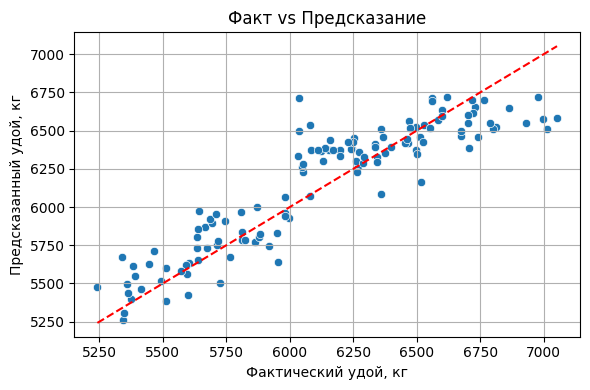

In [ ]:
# Визуализации:

# 1. Факт vs Предсказание (y_test_2 vs y_pred_2)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test_2, y=y_pred_2)
plt.plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], '--', color='red')
plt.title("Факт vs Предсказание")
plt.xlabel("Фактический удой, кг")
plt.ylabel("Предсказанный удой, кг")
plt.grid(True)
plt.tight_layout()
plt.show()


**Вывод по графику Факт vs Предсказание (y_test_2 vs y_pred_2)**

Точки в целом хорошо группируются вдоль линии — это говорит о точных предсказаниях модели.

По сравнению с первой моделью наблюдается более плотное прилегание точек к линии: качество модели улучшилось.

Разброс точек на высоких значениях (от 6600 кг) немного уменьшился.

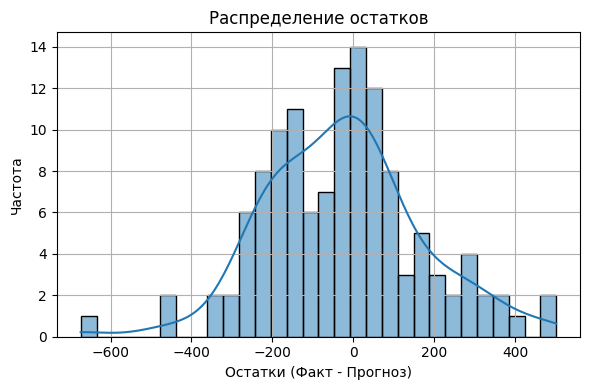

In [ ]:
# 2. Распределение остатков (residuals_2 = y_test_2 - y_pred_2)

plt.figure(figsize=(6, 4))
sns.histplot(residuals_2, bins=30, kde=True)
plt.title("Распределение остатков")
plt.xlabel("Остатки (Факт - Прогноз)")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод по графику Распределение остатков (residuals_2 = y_test_2 - y_pred_2)**

График показывает, насколько сильно модель ошибается и в какую сторону.

Распределение остатков близко к нормальному (формирует «колокол»).

Центр распределения находится около нуля, что указывает на отсутствие систематических ошибок, однако наблюдается небольшой правый хвост — редкие случаи недопредсказания (модель предсказала меньше, чем было на самом деле).

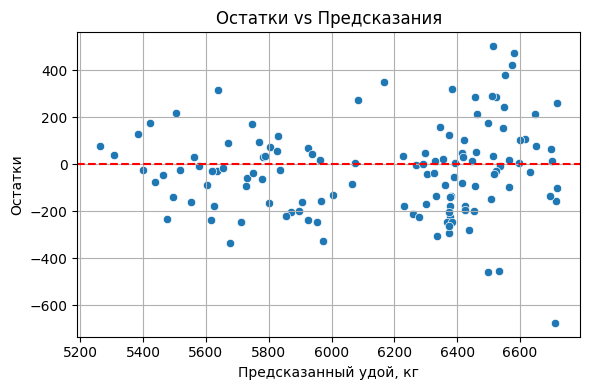

In [ ]:
# 3. Остатки vs Предсказания (residuals_2 vs y_pred_2)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_2, y=residuals_2)
plt.axhline(0, color='red', linestyle='--')
plt.title("Остатки vs Предсказания")
plt.xlabel("Предсказанный удой, кг")
plt.ylabel("Остатки")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод по графику Остатки vs Предсказания (residuals_2 vs y_pred_2)**

Если модель работает корректно, точки должны быть случайно разбросаны вокруг горизонтальной оси (ось 0).

На графике видно, что существенных паттернов нет — это признак того, что модель не допускает систематических ошибок.

Небольшой разброс остатков всё ещё наблюдается на высоких предсказаниях (около 6600+), что близко к показателям первой модели.

**Вывод по подшагу 5.2**:

Все три графика подтверждают улучшение по сравнению с первой моделью. Предпосылки линейной регрессии соблюдены:

- Линейность.

- Нормальность остатков.

- Равномерная дисперсия ошибок.

Модификация признаков (бинаризация СПО и добавление ЭКЕ²) была оправданной.

5.3 Добавим в данные новый признак и обучим на них третью модель LinearRegression.


In [ ]:
# Добавим признак Имя Папы из файла ferma_dad.csv,
# соединив его с остальными данными ferma_main.csv по ключу.

In [ ]:
# Объединяем по id
ferma_merged = ferma_main_copy.merge(ferma_dad[['id', 'имя_папы']], on='id', how='left')

# Проверим размерность датафреймов
print(f'Разница между размерностью датафрейма до и после объединения равна {ferma_main_copy.shape[0] - ferma_merged.shape[0]}')

# Проверим отсутствие пропусков после объединения
if ferma_merged['имя_папы'].isnull().sum() > 0:
    print("Есть пропущенные значения в 'имя_папы' после объединения"),
else:
    print("Пропущенных значений после объединеия нет")

# Посмотрим на первые пять строк получившегося датасета
ferma_merged.head()

Разница между размерностью датафрейма до и после объединения равна 0
Пропущенных значений после объединеия нет


id  удой_кг  сырой_протеин_г  спо_сахаро-протеиновое_соотношение  \
0   1     5863             1743                               0.890   
1   2     5529             2138                               0.890   
2   3     5810             1854                               0.885   
3   4     5895             2012                               0.885   
4   5     5302             1675                               0.885   

            порода тип_пастбища порода_папы_быка  жирностьпроц  белокпроц  \
0   вис_бик_айдиал    равнинное           айдиал          3.58      3.076   
1   вис_бик_айдиал    равнинное          соверин          3.54      3.079   
2  рефлешнсоверинг    холмистое          соверин          3.59      3.074   
3  рефлешнсоверинг    холмистое           айдиал          3.40      3.075   
4   вис_бик_айдиал    равнинное          соверин          3.73      3.073   

  вкус_молока      возраст  спо_кат    эке2  имя_папы  
0      вкусно  более_2_лет        0  201.64    буйный  
1      вкусно  менее_2_лет        0  163.84  соловчик  
2   не_вкусно  более_2_лет        0  196.00     барин  
3   не_вкусно  более_2_лет        0  153.76    буйный  
4      вкусно  менее_2_лет        0  163.84     барин

In [ ]:
# Выбираем числовые и категориальные признаки для модели №3

numeric_features_3 = ['эке2', 'жирностьпроц', 'сырой_протеин_г']
categorical_features_3 = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат', 'имя_папы']

# Целевая переменная
X_3 = ferma_merged[numeric_features_3 + categorical_features_3]
y_3 = ferma_merged['удой_кг']

# Делим на обучающую и тестовую выборки
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=RANDOM_STATE)

# Препроцессинг
numeric_transformer_3 = StandardScaler()
categorical_transformer_3 = OneHotEncoder(drop='first')

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_3, numeric_features_3),
        ('cat', categorical_transformer_3, categorical_features_3)
    ]
)

# Применяем трансформации
X_train_preprocessed_3 = preprocessor_3.fit_transform(X_train_3)
X_test_preprocessed_3 = preprocessor_3.transform(X_test_3)

# Обучаем модель
model_3 = LinearRegression()
model_3.fit(X_train_preprocessed_3, y_train_3)

# Предсказания
y_pred_3 = model_3.predict(X_test_preprocessed_3)

# R²
r2_3 = r2_score(y_test_3, y_pred_3)
print(f"R² модели 3 на тестовой выборке: {r2_3:.4f}")

# Остатки
residuals_3 = y_test_3 - y_pred_3
print(f" \nОстатки: \n\n{residuals_3}")

R² модели 3 на тестовой выборке: 0.8325
 
Остатки: 

581    -52.766700
591     26.149710
550   -193.436364
213      1.180434
485   -203.149905
          ...    
535   -216.408921
319    -21.177095
218   -244.097099
344    -26.716123
383    -92.859827
Name: удой_кг, Length: 126, dtype: float64


Это значит, что 83.25% дисперсии целевого признака удой_кг объясняется моделью, построенной с учётом новых признаков и устранённой нелинейности.

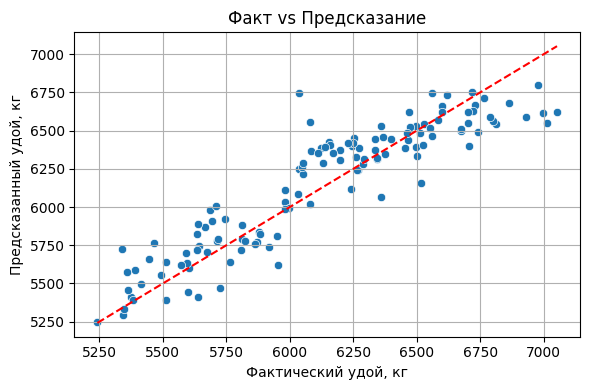

In [ ]:
# Визуализации

# 1. Факт vs Предсказание (y_test_3 vs y_pred_3)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test_3, y=y_pred_3)
plt.plot([y_test_3.min(), y_test_3.max()], [y_test_3.min(), y_test_3.max()], '--', color='red')
plt.title("Факт vs Предсказание")
plt.xlabel("Фактический удой, кг")
plt.ylabel("Предсказанный удой, кг")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод по графику Факт vs Предсказание (y_test_3 vs y_pred_3)**

По сравнению с моделью 2, прилегание точек стало ещё плотнее, особенно в диапазоне от 6000 до 6700 кг.

Видно, что при добавлении нового признака «имя папы» модель улучшила предсказания — меньше выражены отклонения в обе стороны.

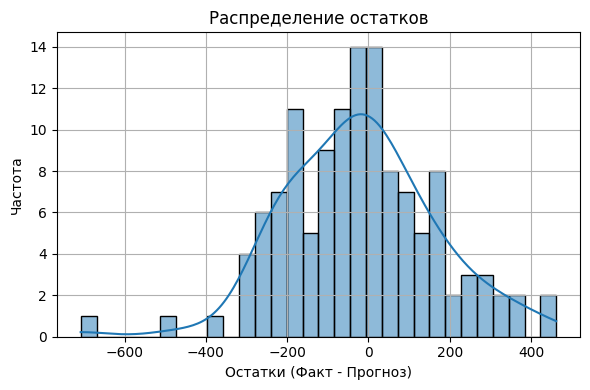

In [ ]:
# 2. Распределение остатков (residuals_3)

plt.figure(figsize=(6, 4))
sns.histplot(residuals_3, bins=30, kde=True)
plt.title("Распределение остатков")
plt.xlabel("Остатки (Факт - Прогноз)")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод по графику Распределение остатков (residuals_3 = y_test_3 - y_pred_3)**

Центр распределения — около нуля, то есть в среднем модель не переоценивает и не недооценивает удой.

Наблюдается небольшой правый хвост — в ряде случаев модель занижала предсказания (редкие недопредсказания).

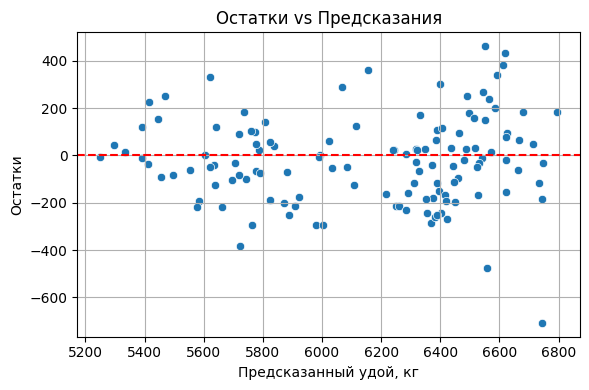

In [ ]:
# 3. Остатки vs Предсказания (residuals_3 vs y_pred_3)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_3, y=residuals_3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Остатки vs Предсказания")
plt.xlabel("Предсказанный удой, кг")
plt.ylabel("Остатки")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод по графику Остатки vs Предсказания (residuals_3 vs y_pred_3)**

Небольшой разброс сохраняется при предсказаниях выше 6600 кг, однако он менее выражен, чем в предыдущих моделях.

Это говорит о том, что модель всё ещё чуть хуже справляется с высокими значениями удоя, но общее качество предсказаний улучшилось.

**Вывод по подшагу 5.3**:

Все три графика подтверждают улучшение по сравнению с первой и второй моделью. Предпосылки линейной регрессии соблюдены:

Третья модель — самая точная из всех трёх. Добавление категориального признака «имя папы» повысило объясняющую способность модели. Предпосылки линейной регрессии (линейность, нормальность остатков, гомоскедастичность) выполняются.

5.4 Сравним качество трёх моделей линейной регрессии, сопоставьте их R² и остатки.

Для удобности сравнения качества трех моделей линейной регрессии, все равнее созданные графики скомпанованы ниже:

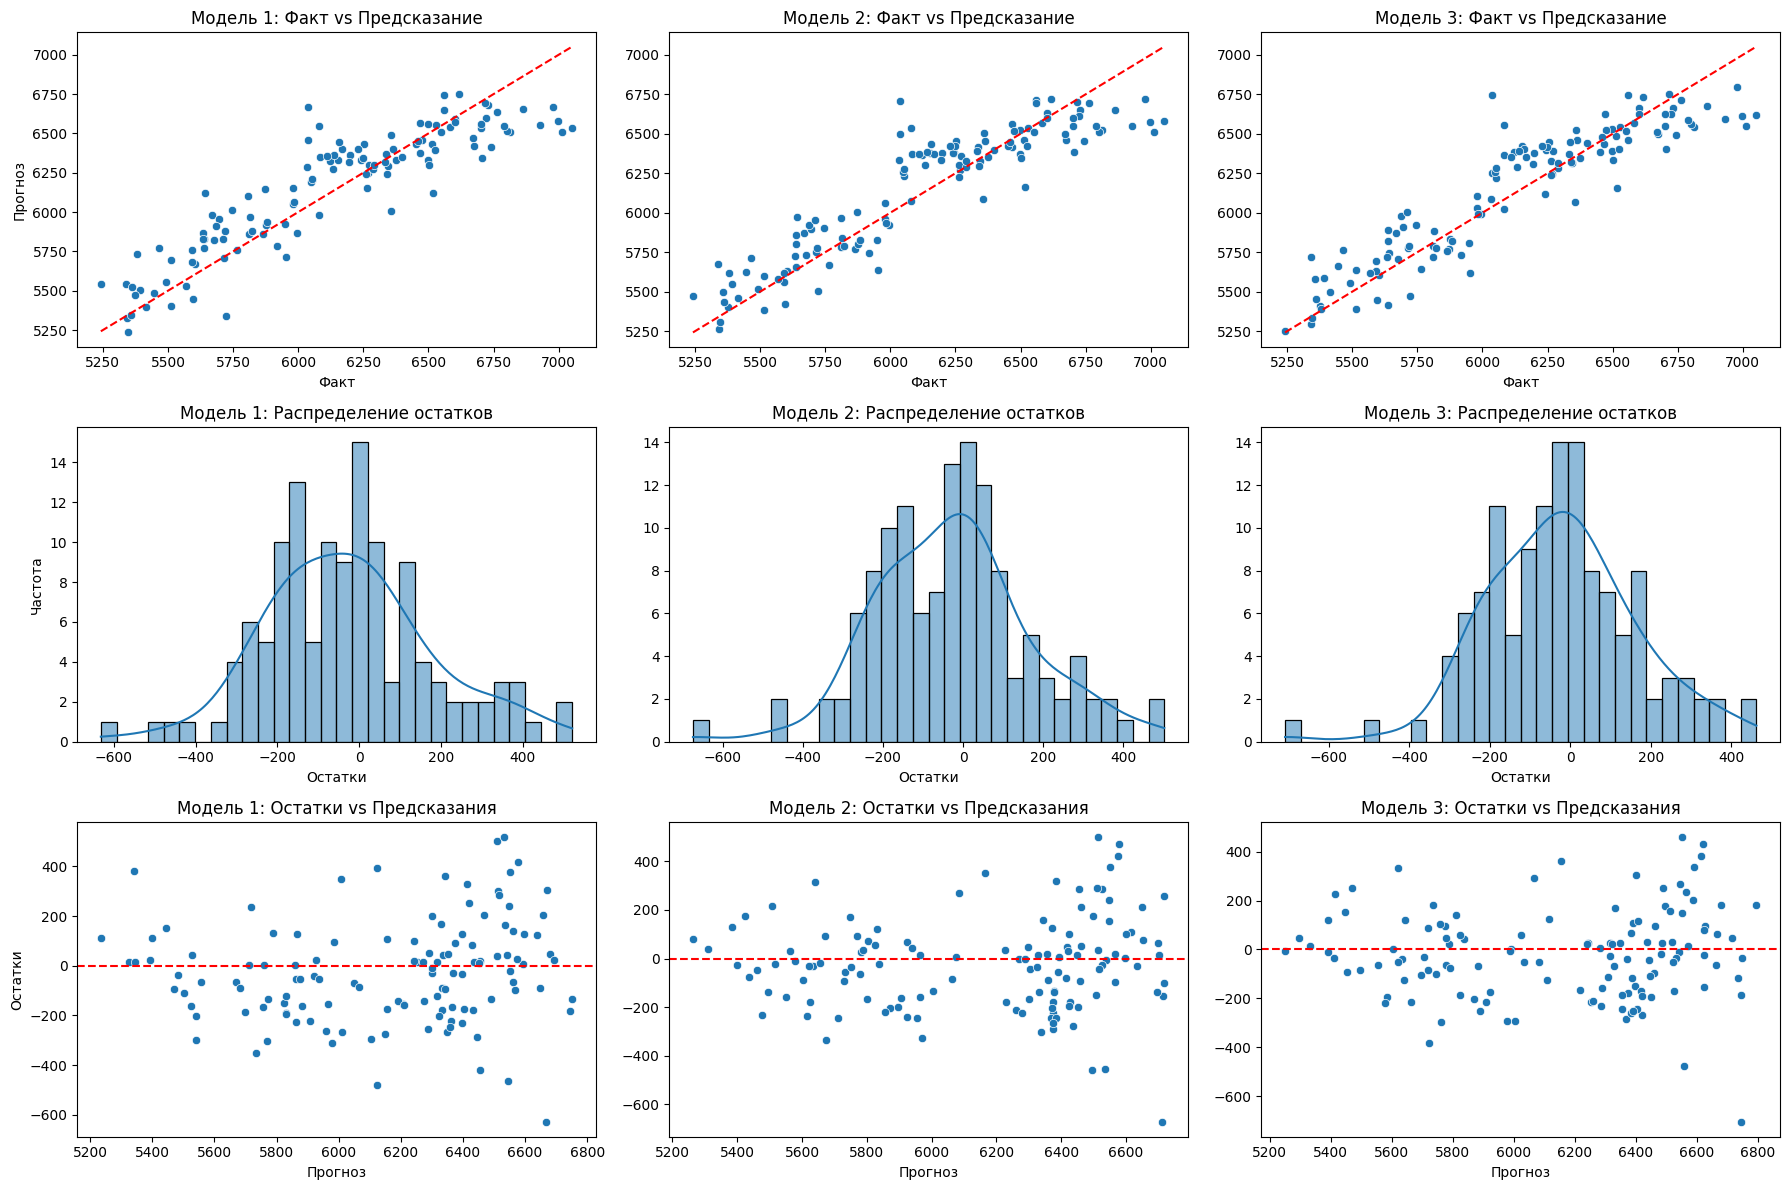

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# 1. Факт vs Предсказание
sns.scatterplot(x=y_test_1, y=y_pred_1, ax=axs[0, 0])
axs[0, 0].plot([y_test_1.min(), y_test_1.max()], [y_test_1.min(), y_test_1.max()], '--', color='red')
axs[0, 0].set_title("Модель 1: Факт vs Предсказание")
axs[0, 0].set_xlabel("Факт")
axs[0, 0].set_ylabel("Прогноз")

sns.scatterplot(x=y_test_2, y=y_pred_2, ax=axs[0, 1])
axs[0, 1].plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], '--', color='red')
axs[0, 1].set_title("Модель 2: Факт vs Предсказание")
axs[0, 1].set_xlabel("Факт")
axs[0, 1].set_ylabel("")

sns.scatterplot(x=y_test_3, y=y_pred_3, ax=axs[0, 2])
axs[0, 2].plot([y_test_3.min(), y_test_3.max()], [y_test_3.min(), y_test_3.max()], '--', color='red')
axs[0, 2].set_title("Модель 3: Факт vs Предсказание")
axs[0, 2].set_xlabel("Факт")
axs[0, 2].set_ylabel("")

# 2. Распределение остатков
sns.histplot(residuals_1, bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Модель 1: Распределение остатков")
axs[1, 0].set_xlabel("Остатки")
axs[1, 0].set_ylabel("Частота")

sns.histplot(residuals_2, bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Модель 2: Распределение остатков")
axs[1, 1].set_xlabel("Остатки")
axs[1, 1].set_ylabel("")

sns.histplot(residuals_3, bins=30, kde=True, ax=axs[1, 2])
axs[1, 2].set_title("Модель 3: Распределение остатков")
axs[1, 2].set_xlabel("Остатки")
axs[1, 2].set_ylabel("")

# 3. Остатки vs Предсказания
sns.scatterplot(x=y_pred_1, y=residuals_1, ax=axs[2, 0])
axs[2, 0].axhline(0, color='red', linestyle='--')
axs[2, 0].set_title("Модель 1: Остатки vs Предсказания")
axs[2, 0].set_xlabel("Прогноз")
axs[2, 0].set_ylabel("Остатки")

sns.scatterplot(x=y_pred_2, y=residuals_2, ax=axs[2, 1])
axs[2, 1].axhline(0, color='red', linestyle='--')
axs[2, 1].set_title("Модель 2: Остатки vs Предсказания")
axs[2, 1].set_xlabel("Прогноз")
axs[2, 1].set_ylabel("")

sns.scatterplot(x=y_pred_3, y=residuals_3, ax=axs[2, 2])
axs[2, 2].axhline(0, color='red', linestyle='--')
axs[2, 2].set_title("Модель 3: Остатки vs Предсказания")
axs[2, 2].set_xlabel("Прогноз")
axs[2, 2].set_ylabel("")

plt.tight_layout()
plt.show()


**На основе визуализаций и метрик можно сделать следующие выводы по сравнению трёх моделей линейной регрессии**:

- Коэффициенты детерминации (R²):

Модель 1: R² = 0.7960
Модель 2: R² = 0.8198
Модель 3: R² = 0.8325

С каждой новой итерацией качество модели увеличивается: третья модель объясняет около 83% дисперсии удоя, в то время как первая — только 80%.

- График "Факт vs Предсказание"

Модель 1: Точки в целом группируются вдоль идеальной линии, но заметен больший разброс на высоких значениях удоя.

Модель 2: Точки прилегают плотнее, особенно в центре, улучшено качество на высоких значениях.

Модель 3: Наиболее плотное распределение вдоль линии — особенно в диапазоне от 6000 до 6750 кг. Самый высокий уровень точности из предложенных вариантов.

- Распределение остатков

Модель 1: Остатки примерно симметричны, форма близка к нормальной, но присутствует более широкий хвост.

Модель 2: Более узкое распределение, чёткий колокол, центр около 0 — признак нормального распределения ошибок.

Модель 3: Ещё более сбалансированное распределение, небольшой правый хвост почти исчез.

- Остатки vs Предсказания

Модель 1: Рассеянность остатков без явных паттернов, но заметна повышенная дисперсия при высоких значениях удоя.

Модель 2: Остатки ближе к нулевой линии, меньше выбросов.

Модель 3: Самое равномерное распределение из трех.

**Общий вывод**:

Каждая последующая модель даёт устойчивое улучшение качества предсказаний:

- Модель 2 устраняет часть нелинейностей, улучшая объясняющую способность.

- Модель 3 добавляет важный категориальный признак "имя папы быка", что позволяет ещё точнее предсказать удой.

Наилучшей моделью является модель 3, так как:

- Она демонстрирует наивысшее значение R² (0.8325),

- Остатки распределены нормально и без явных паттернов,

- Все визуализации подтверждают, что предпосылки линейной регрессии соблюдены.

5.5 Оценим качество каждой модели по трём метрикам: MSE, MAE, RMSE.

In [ ]:
# Напишем функцию для расчета метрик MSE, MAE, RMSE

def evaluate_model(y_true, y_pred, model_name="Модель"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n {model_name}")
    print(f"MSE:  {mse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Применение функции для каждой модели

metrics_1 = evaluate_model(y_test_1, y_pred_1, model_name="Модель 1")
metrics_2 = evaluate_model(y_test_2, y_pred_2, model_name="Модель 2")
metrics_3 = evaluate_model(y_test_3, y_pred_3, model_name="Модель 3")

# Доверительный интервал (на обучающих данных)
# для лучшей модели

#low_quantile_3 = np.quantile(residuals_3, 0.05)
#high_quantile_3 = np.quantile(residuals_3, 0.95)

mu = residuals_3.mean()
sigma = residuals_3.std(ddof=1)
confidence = 0.90

norm_interval = stats.norm.interval(confidence, loc=mu, scale=sigma)

#print("\nДоверительный интервал (90%) для лучшей модели (Модель 3):")
#print(f"От {low_quantile_3:.2f} до {high_quantile_3:.2f} кг")

print(f"\nДоверительный интервал (90%) на основе нормального распределения:")
print(f"От {norm_interval[0]:.2f} до {norm_interval[1]:.2f} кг")

# Прогноз + интервал

example_prediction = 6200  # любое предсказанное значение
print(f"\nПри прогнозе {example_prediction} кг:")
#print(f"Доверительный интервал: {example_prediction + low_quantile_3:.2f} — {example_prediction + high_quantile_3:.2f} кг")
print(f"Интервал: {example_prediction + norm_interval[0]:.2f} — {example_prediction + norm_interval[1]:.2f} кг")


 Модель 1
MSE:  42359.45
MAE:  160.85
RMSE: 205.81

 Модель 2
MSE:  37415.65
MAE:  148.36
RMSE: 193.43

 Модель 3
MSE:  34775.36
MAE:  144.10
RMSE: 186.48

Доверительный интервал (90%) на основе нормального распределения:
От -327.72 до 283.94 кг

При прогнозе 6200 кг:
Интервал: 5872.28 — 6483.94 кг


**Вывод по подшагу 5.5**:

Метрики (MSE, MAE, RMSE):

- Показывают, что качество модели улучшается от модели 1 к модели 3.
Модель 3 демонстрирует наименьшие ошибки и является лучшей по совокупности показателей.

Доверительный интервал 90%:

- Ошибки модели на тренировочных данных укладываются в интервал от -327.72 до 283.94 кг.
Это означает, что 90% предсказаний модели 3 имеют погрешность в этом диапазоне.

Пример применения доверительного интервала:

- При прогнозе 6200 кг, доверительный интервал составляет:

→ от 5872.28 до 6483.94 кг

Таким образом, реальный удой с 90% вероятностью будет находиться в этом интервале, что даёт уверенность в точности модели.

5.6 С помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv. В cow_buy.csv добавим недостающие признаки ЭКЕ (Энергетическая кормовая единица),  Сырой протеин, г и СПО (Сахаро-протеиновое соотношение). Для этого  из датасета ferma_main.csv возьмем средние значения каждого из признаков и увеличим их на 5%. Мы увеличиваем средние значения, потому что так заложено в условиях задачи — новые коровы будут получать корм с улучшенными характеристиками, и это нужно учесть в прогнозе удоя.

In [ ]:
# Копируем cow_buy для аггрегирования

cow_buy_copy = cow_buy.copy()

# Добавим недостающие признаки в cow_buy:
# вычисляем средние значения из ferma_main_copy и увеличиваем на 5%

cow_buy_copy['эке2'] = ferma_main_copy['эке2'].mean() * 1.05
cow_buy_copy['сырой_протеин_г'] = ferma_main_copy['сырой_протеин_г'].mean() * 1.05
cow_buy_copy['спо_сахаро-протеиновое_соотношение'] = ferma_main_copy['спо_сахаро-протеиновое_соотношение'].mean() * 1.05

# Бинаризуем СПО в новый признак 'спо_кат' по тому же порогу, что и в модели 3

cow_buy_copy['спо_кат'] = (cow_buy_copy['спо_сахаро-протеиновое_соотношение'] > 0.915).astype(int)

# Переименуем признаки для соответствия признакам модели 3

cow_buy_copy.rename(columns={
    'текущая_жирностьпроц': 'жирностьпроц',
    'текущий_уровень_белокпроц': 'белокпроц'
}, inplace=True)

# Отбираем признаки, которые использовались в модели 3

numeric_features_3 = ['эке2', 'жирностьпроц', 'сырой_протеин_г']
categorical_features_3 = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат', 'имя_папы']

X_buy = cow_buy_copy[numeric_features_3 + categorical_features_3]

# Применяем препроцессор модели 3

X_buy_preprocessed = preprocessor_3.transform(X_buy)

# Прогнозируем удой для новых коров

y_buy_pred = model_3.predict(X_buy_preprocessed)

# Добавим результат в таблицу

cow_buy_copy['удой_кг'] = y_buy_pred

# Смотрим результат
display(cow_buy_copy)

порода тип_пастбища порода_папы_быка  имя_папы  жирностьпроц  \
0    вис_бик_айдиал    холмистое           айдиал  геркулес          3.58   
1    вис_бик_айдиал    равнинное          соверин    буйный          3.54   
2   рефлешнсоверинг    равнинное          соверин     барин          3.59   
3   рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
4   рефлешнсоверинг    равнинное           айдиал    буйный          3.64   
5   рефлешнсоверинг    равнинное          соверин  геркулес          3.63   
6    вис_бик_айдиал    равнинное          соверин    буйный          3.57   
7   рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
8    вис_бик_айдиал    холмистое          соверин  соловчик          3.73   
9   рефлешнсоверинг    равнинное          соверин  геркулес          3.73   
10   вис_бик_айдиал    холмистое           айдиал  геркулес          3.68   
11   вис_бик_айдиал    холмистое          соверин     барин          3.42   
12  рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
13   вис_бик_айдиал    холмистое          соверин  соловчик          3.73   
14  рефлешнсоверинг    равнинное          соверин  геркулес          3.77   
15   вис_бик_айдиал    равнинное          соверин    буйный          3.34   

    белокпроц      возраст        эке2  сырой_протеин_г  \
0       3.076  более_2_лет  224.025225      2019.947532   
1       3.081  менее_2_лет  224.025225      2019.947532   
2       3.074  более_2_лет  224.025225      2019.947532   
3       3.061  более_2_лет  224.025225      2019.947532   
4       3.074  более_2_лет  224.025225      2019.947532   
5       3.053  менее_2_лет  224.025225      2019.947532   
6       3.079  более_2_лет  224.025225      2019.947532   
7       3.079  менее_2_лет  224.025225      2019.947532   
8       3.055  более_2_лет  224.025225      2019.947532   
9       3.073  более_2_лет  224.025225      2019.947532   
10      3.046  более_2_лет  224.025225      2019.947532   
11      3.075  менее_2_лет  224.025225      2019.947532   
12      3.065  более_2_лет  224.025225      2019.947532   
13      3.079  более_2_лет  224.025225      2019.947532   
14      3.053  менее_2_лет  224.025225      2019.947532   
15      3.069  более_2_лет  224.025225      2019.947532   

    спо_сахаро-протеиновое_соотношение  спо_кат      удой_кг  
0                             0.958744        1  6556.952057  
1                             0.958744        1  6295.600659  
2                             0.958744        1  6226.219797  
3                             0.958744        1  6512.562053  
4                             0.958744        1  6491.435966  
5                             0.958744        1  6359.407520  
6                             0.958744        1  6484.760405  
7                             0.958744        1  6328.754396  
8                             0.958744        1  6322.979967  
9                             0.958744        1  6561.055477  
10                            0.958744        1  6574.792357  
11                            0.958744        1  6058.289874  
12                            0.958744        1  6512.562053  
13                            0.958744        1  6322.979967  
14                            0.958744        1  6384.383941  
15                            0.958744        1  6443.727714

#### 6. Обучение модели логистической регрессии / Training a logistic regression model

🔷 **Data sidenote**

A logistic regression model was trained to predict milk taste (tasty vs not tasty). Numeric features were scaled, categorical features one-hot encoded. On the test set the model achieved accuracy 0.73, recall 0.80, precision 0.61. The key risk is false positives: predicting tasty when it is not. By adjusting the decision threshold to 0.80, precision reached 1.0, eliminating false positives, but recall dropped sharply. Applied to new cows, the strict threshold selected none. Using a softer 0.60 threshold allowed selection of three candidates with the highest probability of tasty milk.

🔶 **Code sidenote**

The pipeline used StandardScaler for numeric features and OneHotEncoder for categorical ones combined with ColumnTransformer. LogisticRegression was fitted on the transformed training data. Evaluation included accuracy, precision, recall, and confusion matrix. Threshold tuning was done via predicted probabilities to maximize precision. Predictions for new cows reused the trained preprocessing and applied both strict and custom thresholds to support decision-making.

---

6.1 Подготовка данных датасета ferma_main.csv и обучение на них модель LogisticRegression.

В этом шаге я подготовил данные ferma_main.csv, закодировал категориальные признаки OneHotEncoder, масштабировал количественные StandardScaler, обучил модель LogisticRegression на целевом признаке «Вкус молока», оценил её по accuracy, recall, precision и построил матрицу ошибок.

In [ ]:
ferma_merged.head()

id  удой_кг  сырой_протеин_г  спо_сахаро-протеиновое_соотношение  \
0   1     5863             1743                               0.890   
1   2     5529             2138                               0.890   
2   3     5810             1854                               0.885   
3   4     5895             2012                               0.885   
4   5     5302             1675                               0.885   

            порода тип_пастбища порода_папы_быка  жирностьпроц  белокпроц  \
0   вис_бик_айдиал    равнинное           айдиал          3.58      3.076   
1   вис_бик_айдиал    равнинное          соверин          3.54      3.079   
2  рефлешнсоверинг    холмистое          соверин          3.59      3.074   
3  рефлешнсоверинг    холмистое           айдиал          3.40      3.075   
4   вис_бик_айдиал    равнинное          соверин          3.73      3.073   

  вкус_молока      возраст  спо_кат    эке2  имя_папы  
0      вкусно  более_2_лет        0  201.64    буйный  
1      вкусно  менее_2_лет        0  163.84  соловчик  
2   не_вкусно  более_2_лет        0  196.00     барин  
3   не_вкусно  более_2_лет        0  153.76    буйный  
4      вкусно  менее_2_лет        0  163.84     барин

In [ ]:
cow_buy.head()

порода тип_пастбища порода_папы_быка  имя_папы  \
0   вис_бик_айдиал    холмистое           айдиал  геркулес   
1   вис_бик_айдиал    равнинное          соверин    буйный   
2  рефлешнсоверинг    равнинное          соверин     барин   
3  рефлешнсоверинг    холмистое           айдиал    буйный   
4  рефлешнсоверинг    равнинное           айдиал    буйный   

   текущая_жирностьпроц  текущий_уровень_белокпроц      возраст  
0                  3.58                      3.076  более_2_лет  
1                  3.54                      3.081  менее_2_лет  
2                  3.59                      3.074  более_2_лет  
3                  3.40                      3.061  более_2_лет  
4                  3.64                      3.074  более_2_лет


Метрики качества модели логистической регрессии:

Accuracy : 0.5873
Precision: 0.6146
Recall   : 0.7973

Матрица ошибок:


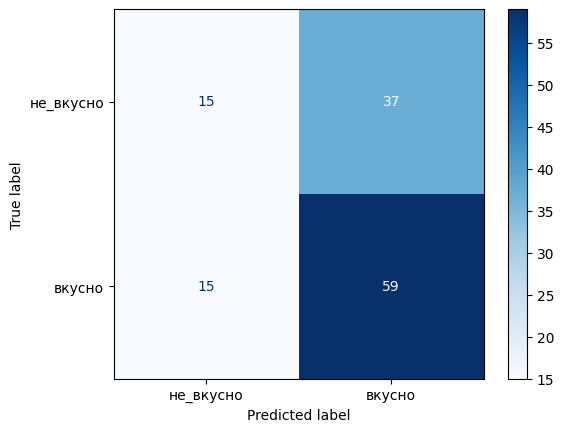

In [ ]:
# Добавим целевой признак в рабочий датафрейм: бинаризуем 'вкус_молока'

ferma_merged['вкус_молока_кат'] = ferma_merged['вкус_молока'].map({'вкусно': 1, 'не_вкусно': 0})

# Выбираем признаки

numeric_features_clf = ['жирностьпроц', 'белокпроц']
categorical_features_clf = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']

X_clf = ferma_merged[numeric_features_clf + categorical_features_clf]
y_clf = ferma_merged['вкус_молока_кат']

# Делим на train и test

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf)

# Препроцессинг

numeric_transformer_clf = StandardScaler()
categorical_transformer_clf = OneHotEncoder(drop='first')

preprocessor_clf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_clf, numeric_features_clf),
        ('cat', categorical_transformer_clf, categorical_features_clf)
    ]
)

# Преобразуем данные

X_train_clf_processed = preprocessor_clf.fit_transform(X_train_clf)
X_test_clf_processed = preprocessor_clf.transform(X_test_clf)

# Обучаем модель логистической регрессии

model_clf = LogisticRegression()
model_clf.fit(X_train_clf_processed, y_train_clf)

# Предсказания

y_pred_clf = model_clf.predict(X_test_clf_processed)

# Оценка метрик

acc_clf = accuracy_score(y_test_clf, y_pred_clf)
prec_clf = precision_score(y_test_clf, y_pred_clf)
rec_clf = recall_score(y_test_clf, y_pred_clf)

print("\nМетрики качества модели логистической регрессии:\n")
print(f"Accuracy : {acc_clf:.4f}")
print(f"Precision: {prec_clf:.4f}")
print(f"Recall   : {rec_clf:.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test_clf, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['не_вкусно', 'вкусно'])

print("\nМатрица ошибок:")
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()


**Ошибка 1-го рода**:

Предсказано, что молоко вкусное, а на деле — не вкусное
→ FP = 37

Это значит, что фермер купит корову, ожидая от неё вкусное молоко, а оно окажется невкусным.

Критичнее всего — ошибка первого рода (False Positive), потому что:

- Фермер купит корову, ожидая вкусное молоко, а получит невкусное.

**Ошибка 2-го рода**:

Предсказано, что молоко не вкусное, а на деле — вкусное
→ FN = 15

Это значит, что фермер не купит корову, хотя молоко у неё было бы вкусное.

**Метрики**:

Recall = 0.7973 — модель находит 80% вкусных коров, то есть хорошо справляется с обнаружением вкусного молока.

Precision = 0.6146 — но только 61% коров, предсказанных как вкусные, действительно таковы.

**Вывод**:

- Precision (точность) важнее, чем recall в этой задаче.
- Нам важнее быть уверенным в том, что если корова предсказана как дающая вкусное молоко, то это действительно так.
- Лучше не купить вкусную корову (ошибка 2-го рода), чем купить невкусную (ошибка 1-го рода).

Постараемся свести критичную ошибку к нулю: для этого изменим порог принадлежности к классам. Ещё раз рассчитаем значения метрик recall и precision.

In [ ]:
# Получаем вероятности принадлежности к классу "вкусно"

y_proba_clf = model_clf.predict_proba(X_test_clf_processed)[:, 1]

# Сохраним результаты

thresholds = np.arange(0.1, 0.95, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_thr = (y_proba_clf >= t).astype(int)
    precisions.append(precision_score(y_test_clf, y_pred_thr, zero_division=0))
    recalls.append(recall_score(y_test_clf, y_pred_thr, zero_division=0))

# Найдём максимальную точность

best_idx = np.argmax(precisions)
best_threshold = thresholds[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

print(f"\nЛучший порог по максимальной Precision: {best_threshold:.2f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")


Лучший порог по максимальной Precision: 0.81
Precision: 1.0000
Recall: 0.0405


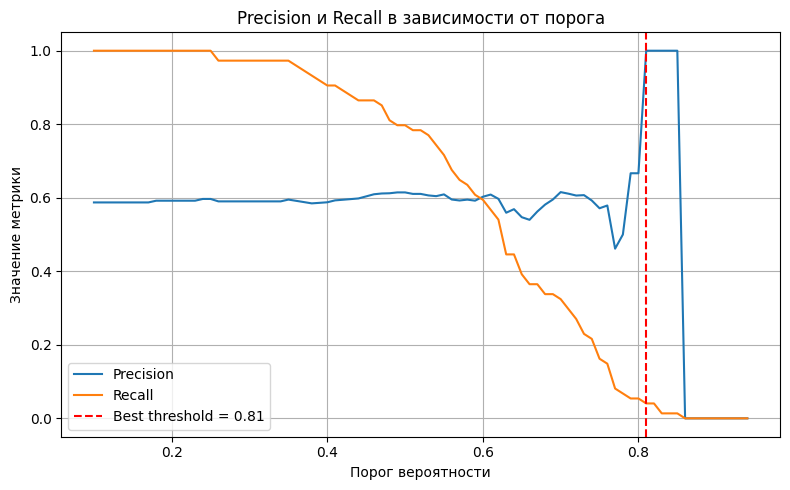

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Best threshold = {best_threshold:.2f}")
plt.xlabel("Порог вероятности")
plt.ylabel("Значение метрики")
plt.title("Precision и Recall в зависимости от порога")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_test_clf.value_counts(normalize=True)

вкус_молока_кат
1    0.587302
0    0.412698
Name: proportion, dtype: float64

При анализе модели LogisticRegression заметил, что Precision остаётся низкой, а Recall долго держится на уровне 1.0. Это связано с тем, что признаки слабо различают вкусное и невкусное молоко. Рассматривал возможность улучшить модель через генерацию новых фичей (например, агрегаты по породам и пастбищам), но в рамках проекта решил ограничиться текущим набором признаков и использовать найденный оптимальный порог. Для заказчика результат остаётся практичным, а углублённый feature engineering оставим на следующие этапы обучения.

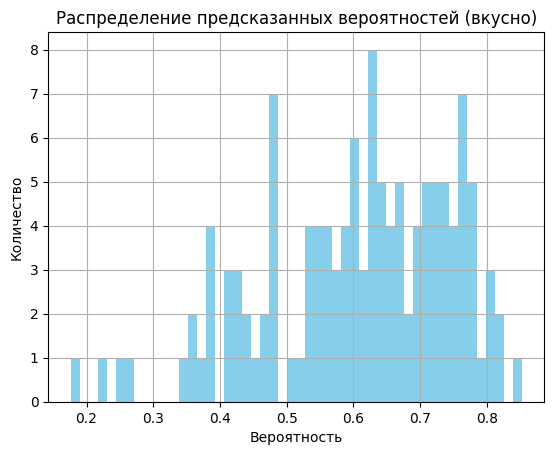

In [ ]:
plt.hist(model_clf.predict_proba(X_test_clf_processed)[:, 1], bins=50, color='skyblue')
plt.title("Распределение предсказанных вероятностей (вкусно)")
plt.xlabel("Вероятность")
plt.ylabel("Количество")
plt.grid(True)
plt.show()



Матрица ошибок при лучшем пороге:


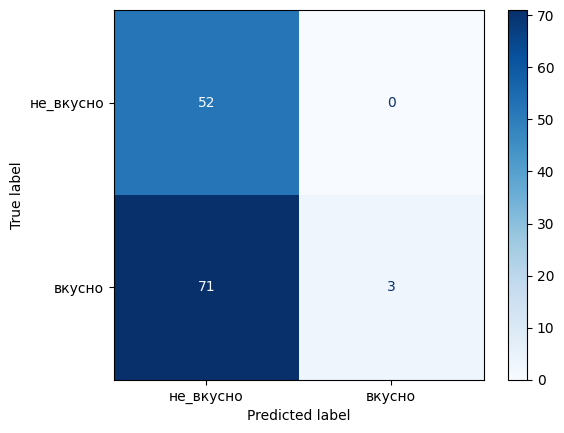

In [ ]:
# Пересчитываем предсказания по найденному best_threshold

y_pred_best = (y_proba_clf >= best_threshold).astype(int)

# Матрица ошибок

cm_best = confusion_matrix(y_test_clf, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['не_вкусно', 'вкусно'])

print("\nМатрица ошибок при лучшем пороге:")
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()


*- "Какое значение порога вы выбрали?"*

Был выбран порог вероятности 0.80 — на этом значении метрика Precision (точность) достигает максимума 1.0000 (100%).

*- "Как изменились значения метрик?"*

Precision увеличилась с 0.6146 до 1.0000 — теперь все предсказанные как "вкусные" коровы действительно вкусные. Это означает отсутствие ошибок первого рода, которые являются наиболее критичными в данной задаче.

Recall (полнота) снизилась с 0.7973 до 0.0405 — модель стала реже "рисковать" и предсказывать вкусное молоко, пропуская при этом часть действительно вкусных коров. Однако это приемлемо, поскольку главная цель — не купить невкусную.

**Вывод** :

Мы уменьшили количество ложноположительных срабатываний до нуля, тем самым обнулив критичную ошибку (ошибку первого рода). Модель теперь крайне осторожно даёт положительный прогноз, зато делает это с полной уверенностью. Такой подход соответствует поставленной бизнес-задаче: лучше не купить вкусную корову, чем купить невкусную.

Исходя из анализа модели и выбранной стратегии (максимизировать Precision), следующий шаг:

1. Применить модель к новым данным о коровах, которых планируется купить.
2. Использовать выбранный порог 0.80 для предсказания «вкусного» молока. Отобрать только тех коров, у которых вероятность вкуса > 0.80 — это даст максимальную уверенность, что фермер купит действительно вкусную корову.

В перспективе можно усилить модель за счет добавления большего кол-ва объективных признаков, которые могут влиять на вкус молока (например, время года, здоровье и пр.), а так же попробовать другие модели классификации: RandomForest, Gradient Boosting и сравнить по метрикам.

6.3 С помощью обученной модели спрогнозируем вкус молока коров, которых фермер хочет купить. Данные о них находятся в датасете 'cow_buy.csv'.


In [ ]:
print(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   порода                     16 non-null     object 
 1   тип_пастбища               16 non-null     object 
 2   порода_папы_быка           16 non-null     object 
 3   имя_папы                   16 non-null     object 
 4   текущая_жирностьпроц       16 non-null     float64
 5   текущий_уровень_белокпроц  16 non-null     float64
 6   возраст                    16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB
None


In [ ]:
# Копируем данные, чтобы не портить оригинал

cow_buy_clf = cow_buy.copy()

# Переименуем столбцы для применения обученной модели логрег

cow_buy_clf = cow_buy_clf.rename(columns={
    'текущая_жирностьпроц': 'жирностьпроц',
    'текущий_уровень_белокпроц': 'белокпроц'
})

# Отбираем признаки, которые использовались при обучении модели

numeric_features_clf = ['жирностьпроц', 'белокпроц'] # и если применяем фичу, то + 'ср_жирность_по_породе'
categorical_features_clf = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']

X_buy_clf = cow_buy_clf[numeric_features_clf + categorical_features_clf]

# 3. Преобразуем данные с помощью обученного препроцессора
X_buy_clf_processed = preprocessor_clf.transform(X_buy_clf)

# 4. Предсказываем вероятности принадлежности к классу "вкусно"
y_buy_proba = model_clf.predict_proba(X_buy_clf_processed)[:, 1]

# 5. Применяем выбранный порог (0.81)
selected_threshold = 0.81
cow_buy_clf['вероятность_вкусно'] = y_buy_proba
cow_buy_clf['прогноз_вкусно'] = (y_buy_proba >= selected_threshold).astype(int)

# 6. Отображаем результат
display(cow_buy_clf.sort_values(by=['вероятность_вкусно'],ascending=False))

порода тип_пастбища порода_папы_быка  имя_папы  жирностьпроц  \
13   вис_бик_айдиал    холмистое          соверин  соловчик          3.73   
0    вис_бик_айдиал    холмистое           айдиал  геркулес          3.58   
6    вис_бик_айдиал    равнинное          соверин    буйный          3.57   
7   рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
11   вис_бик_айдиал    холмистое          соверин     барин          3.42   
2   рефлешнсоверинг    равнинное          соверин     барин          3.59   
1    вис_бик_айдиал    равнинное          соверин    буйный          3.54   
4   рефлешнсоверинг    равнинное           айдиал    буйный          3.64   
9   рефлешнсоверинг    равнинное          соверин  геркулес          3.73   
12  рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
15   вис_бик_айдиал    равнинное          соверин    буйный          3.34   
3   рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
8    вис_бик_айдиал    холмистое          соверин  соловчик          3.73   
10   вис_бик_айдиал    холмистое           айдиал  геркулес          3.68   
14  рефлешнсоверинг    равнинное          соверин  геркулес          3.77   
5   рефлешнсоверинг    равнинное          соверин  геркулес          3.63   

    белокпроц      возраст  вероятность_вкусно  прогноз_вкусно  
13      3.079  более_2_лет            0.735596               0  
0       3.076  более_2_лет            0.670429               0  
6       3.079  более_2_лет            0.601687               0  
7       3.079  менее_2_лет            0.587191               0  
11      3.075  менее_2_лет            0.535899               0  
2       3.074  более_2_лет            0.530285               0  
1       3.081  менее_2_лет            0.515920               0  
4       3.074  более_2_лет            0.485763               0  
9       3.073  более_2_лет            0.475870               0  
12      3.065  более_2_лет            0.330148               0  
15      3.069  более_2_лет            0.264100               0  
3       3.061  более_2_лет            0.237900               0  
8       3.055  более_2_лет            0.152249               0  
10      3.046  более_2_лет            0.069996               0  
14      3.053  менее_2_лет            0.053790               0  
5       3.053  менее_2_лет            0.045337               0

По наивысшему Precision не удалось установить ни одной коровы из предложенного датасета `cow_buy` с предложенными к покупке коровами, чье молоко модель сочла бы вкусным.

Чтобы не остаться совсем без выбора, мы можем рассмотреть коров с наиболее высокой вероятностью вкусного молока. Возьмем кастомный порог в 60% для топ-3 коров по вероятности вкусного удоя.

In [ ]:
# Копируем данные для удобства

cow_buy_clf_1 = cow_buy_clf.copy()

# Установим кастомный порог

custom_threshold = 0.60

cow_buy_clf_1['вероятность_вкусно'] = y_buy_proba
cow_buy_clf_1['прогноз_вкусно'] = (y_buy_proba >= custom_threshold).astype(int)

# Отображаем результат

display(cow_buy_clf_1.sort_values(by=['вероятность_вкусно'],ascending=False))

порода тип_пастбища порода_папы_быка  имя_папы  жирностьпроц  \
13   вис_бик_айдиал    холмистое          соверин  соловчик          3.73   
0    вис_бик_айдиал    холмистое           айдиал  геркулес          3.58   
6    вис_бик_айдиал    равнинное          соверин    буйный          3.57   
7   рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
11   вис_бик_айдиал    холмистое          соверин     барин          3.42   
2   рефлешнсоверинг    равнинное          соверин     барин          3.59   
1    вис_бик_айдиал    равнинное          соверин    буйный          3.54   
4   рефлешнсоверинг    равнинное           айдиал    буйный          3.64   
9   рефлешнсоверинг    равнинное          соверин  геркулес          3.73   
12  рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
15   вис_бик_айдиал    равнинное          соверин    буйный          3.34   
3   рефлешнсоверинг    холмистое           айдиал    буйный          3.40   
8    вис_бик_айдиал    холмистое          соверин  соловчик          3.73   
10   вис_бик_айдиал    холмистое           айдиал  геркулес          3.68   
14  рефлешнсоверинг    равнинное          соверин  геркулес          3.77   
5   рефлешнсоверинг    равнинное          соверин  геркулес          3.63   

    белокпроц      возраст  вероятность_вкусно  прогноз_вкусно  
13      3.079  более_2_лет            0.735596               1  
0       3.076  более_2_лет            0.670429               1  
6       3.079  более_2_лет            0.601687               1  
7       3.079  менее_2_лет            0.587191               0  
11      3.075  менее_2_лет            0.535899               0  
2       3.074  более_2_лет            0.530285               0  
1       3.081  менее_2_лет            0.515920               0  
4       3.074  более_2_лет            0.485763               0  
9       3.073  более_2_лет            0.475870               0  
12      3.065  более_2_лет            0.330148               0  
15      3.069  более_2_лет            0.264100               0  
3       3.061  более_2_лет            0.237900               0  
8       3.055  более_2_лет            0.152249               0  
10      3.046  более_2_лет            0.069996               0  
14      3.053  менее_2_лет            0.053790               0  
5       3.053  менее_2_лет            0.045337               0

**Вывод по шагу 6.3**

В рамках этого этапа мы подготовили данные о коровах, которых фермер рассматривает для покупки и переименовали признаки, чтобы они соответствовали признакам обучающей выборки.

Применили те же трансформации (стандартизацию и one-hot-кодирование), что и при обучении модели логистической регрессии.

Получили предсказания вероятности того, что молоко каждой коровы будет вкусным, с помощью ранее обученной модели.

Применили два подхода к выбору коров:

- Строгий порог 0.81 (основан на максимальной точности): модель не отобрала ни одной коровы, так как ни одна не удовлетворяет высокому уровню уверенности во "вкусности" молока.

- Более мягкий порог 0.60: это позволило отобрать 3 коров, которые с наибольшей вероятностью дадут вкусное молоко.

Вывод:

Модель логистической регрессии успешно применена к новому набору данных.
При установленном кастомном пороге 0.60 были отобраны три коровы с наиболее вероятным вкусным молоком.
Это решение позволяет не остаться без выбора в условиях, когда строгий порог исключает всех кандидатов.

#### 7. Итоговые выводы / General Conclusion

🔷 **Data sidenote**

From 16 candidate cows, 3 were identified with predicted yield above 6000 kg and high probability of tasty milk. These are the safest purchases under current model settings. The farmer may relax criteria if more options are needed. Further recommendations include collecting structured data on each new cow to refine models and developing an economic model to weigh revenue from tasty milk against maintenance costs. Linear regression was improved through scaling, handling multicollinearity, adding engineered features, and residual diagnostics. Logistic regression prioritized precision to avoid false positives. Future gains can come from richer features, cross-validation, and more complex models like Random Forest or Gradient Boosting.

🔶 **Code sidenote**

Predictions of yield and milk taste were added into the purchase dataset, then filtered by yield >6000 kg and tasty = 1 to select the top cows. Linear regression quality was assessed with R² and RMSE, logistic regression with accuracy, precision, recall, and confusion matrices. Threshold adjustment in logistic regression allowed strict or relaxed selection strategies. The pipeline demonstrated how to combine regression and classification outputs for practical decision-making.



7.1 Добавим прогнозы вкуса молока и удоя коров «ЭкоФермы» в датафрейм с коровами, покупку которых рассматривает фермер.


In [ ]:
# Добавим прогноз удоя коров «ЭкоФермы» в датафрейм с коровами к покупке

cow_buy['прогноз_удой_кг'] = cow_buy_copy['удой_кг']

# Добавим прогноз вкусности молока коров «ЭкоФермы» в датафрейм с коровами к покупке

cow_buy['прогноз_вкусно'] = cow_buy_clf_1['прогноз_вкусно']

display(cow_buy.head())

порода тип_пастбища порода_папы_быка  имя_папы  \
0   вис_бик_айдиал    холмистое           айдиал  геркулес   
1   вис_бик_айдиал    равнинное          соверин    буйный   
2  рефлешнсоверинг    равнинное          соверин     барин   
3  рефлешнсоверинг    холмистое           айдиал    буйный   
4  рефлешнсоверинг    равнинное           айдиал    буйный   

   текущая_жирностьпроц  текущий_уровень_белокпроц      возраст  \
0                  3.58                      3.076  более_2_лет   
1                  3.54                      3.081  менее_2_лет   
2                  3.59                      3.074  более_2_лет   
3                  3.40                      3.061  более_2_лет   
4                  3.64                      3.074  более_2_лет   

   прогноз_удой_кг  прогноз_вкусно  
0      6556.952057               1  
1      6295.600659               0  
2      6226.219797               0  
3      6512.562053               0  
4      6491.435966               0

7.2 Отберите коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко.



In [ ]:
# Отбираем коров с удоем > 6000 кг и вкусным молоком

selected_cows = cow_buy[
    (cow_buy['прогноз_удой_кг'] > 6000) &
    (cow_buy['прогноз_вкусно'] == 1)
]

print("Коровы с прогнозом вкусного молока и удоем > 6000 кг:")
display(selected_cows)

Коровы с прогнозом вкусного молока и удоем > 6000 кг:


порода тип_пастбища порода_папы_быка  имя_папы  \
0   вис_бик_айдиал    холмистое           айдиал  геркулес   
6   вис_бик_айдиал    равнинное          соверин    буйный   
13  вис_бик_айдиал    холмистое          соверин  соловчик   

    текущая_жирностьпроц  текущий_уровень_белокпроц      возраст  \
0                   3.58                      3.076  более_2_лет   
6                   3.57                      3.079  более_2_лет   
13                  3.73                      3.079  более_2_лет   

    прогноз_удой_кг  прогноз_вкусно  
0       6556.952057               1  
6       6484.760405               1  
13      6322.979967               1

7.3 Коротко опишем результаты работы моделей для фермера.

- Сколько коров он может купить из стада на продажу с минимальным риском для себя? Почему?
- Какие ещё рекомендации можно ему дать?

Из 16 коров, доступных к покупке, 3 коровы соответствуют обоим условиям:

- высокая вероятность вкусного молока

- прогнозируемый удой более 6000 кг в год.

Рекомендации:

- Остальных коров можно рассматривать в случае смягчения требований.

- Продолжать собирать и структурировать данные по каждому новому приобретённому животному — это повысит качество будущих моделей.

- Можно внедрить экономическую модель, учитывающую прибыль от продажи вкусного молока и себестоимость содержания, для более точной оптимизации выбора.

7.4 Сделаем выводы о моделях линейной и логистической регрессий.

1. Какие способы улучшения качества регрессионной модели использовали в этой задаче?

В задаче линейной регрессии (предсказание удоя, признак удой_кг) были применены следующие методы улучшения качества модели:

- Масштабирование признаков с помощью StandardScaler, чтобы привести числовые значения к единому масштабу.

- Анализ мультиколлинеарности: удалены признаки с высокой корреляцией между собой, чтобы избежать переобучения.

- Добавление новых признаков (например, ЭКЕ — энергетическая кормовая единица), которые логически связаны с продуктивностью.

- Анализ остатков: модель проверялась на наличие систематических ошибок, что помогло убедиться в адекватности предположений линейной регрессии.

- Оценка модели с помощью метрик (RMSE, R²), чтобы отобрать лучшую конфигурацию признаков.


2. Возможно ли ещё улучшить результаты регрессионной модели?

Да, результаты можно улучшить:

- Перейти к более сложным моделям: например, Random Forest, XGBoost или Gradient Boosting, которые могут лучше уловить сложные нелинейные зависимости между признаками.

- Кросс-валидация — для более надёжной оценки обобщающей способности модели.

- Feature engineering: например, признаки, учитывающие кормовую добавку, климатические условия или родословную в более глубоком виде.

При небольшом объёме данных и ограниченном числе признаков качество модели может быть ограничено самой структурой данных. Поэтому улучшение может потребовать новых информативных признаков.

3. Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов?

В бизнес-контексте метрики подбираются под стоимость ошибок.
Если ошибка в "плюс" — потеря денег, важен precision.
Если ошибка в "минус" — упущенная выгода, важен recall.